# Modelo demanada

## 1. Construcción base de datos para el modelo de absorción

En esta primera parte del código lo que hicimos fue **convertir los Excels operativos** (Ventas, Prototipos, Amenidades, etc.) en una tabla limpia y estructurada lista para modelar la **absorción mensual de vivienda por proyecto**.

### 1.1. Definir la variable objetivo: Absorción promedio mensual por proyecto

Creamos la función `calcular_absorcion_mensual(...)` para calcular, para cada proyecto y cada periodo de ventas, **cuántas viviendas se venden en promedio por mes**.

La idea de negocio detrás es:

- La métrica relevante para comparar proyectos es la **velocidad de ventas**.

La función hace lo siguiente:

1. Unimos la hoja **Ventas** con las hojas **Vertical**, **Horizontal** y **Lote** para recuperar la `Fecha_inicio_venta` por proyecto.
2. Para cada proyecto:
   - En el **primer registro**:
     - Calculamos los meses entre la `Fecha_inicio_venta` y la primera `Fecha` en la hoja de ventas.
     - `Absorcion_prom_mensual = Ventas_periodo / meses_transcurridos`.
   - En los **registros siguientes**:
     - Calculamos los meses entre la fecha actual y la fecha del registro anterior.
     - Volvemos a dividir `Ventas_periodo / meses_del_periodo`.
3. Así obtenemos una columna nueva: **`Absorcion_prom_mensual`**, que será nuestra **variable objetivo (Y)**.


### 1.2. Incorporar el precio promedio por proyecto y fecha

Después trabajamos con la hoja **Precios**:

1. Aseguramos que la columna `Fecha` sea tipo fecha tanto en `precios_df` como en `ventas_con_abs_vf`.
2. Buscamos la columna de precio (en este caso `"Precio"`), la convertimos a numérica y **excluimos** los prototipos con precio `0`.
3. Calculamos el **precio promedio por proyecto y fecha**:

   - Agrupamos por `Fecha` y `Nombre_desarrollo`.
   - Tomamos el promedio de `Precio` y lo renombramos como `Precio_promedio`.

4. Hacemos un `merge` para agregar `Precio_promedio` a la tabla de ventas con absorción (`ventas_con_abs_vf`).


### 1.3. Incorporar el M2 promedio y el Precio por m²

Repetimos la misma lógica, pero ahora para los metros cuadrados:

1. Identificamos la columna de m² (en este caso `"M2"`).
2. Convertimos la columna a numérica y filtramos registros con m² > 0.
3. Calculamos el **M2 promedio por proyecto y fecha**: `M2_promedio`.
4. Volvemos a hacer un `merge` con la tabla principal.

Con esto podemos construir:

- `Precio_por_M2 = Precio_promedio / M2_promedio`

que es una forma más comparable de ver el precio entre proyectos de distinto tamaño.


### 1.4. Rellenar precio en periodos sin inventario

Hay fechas donde:

- El inventario disponible es 0.
- No hay registro de precio ese mes.
- Pero el proyecto no está marcado como "Ventas detenidas".

Para no perder esos registros:

1. Ordenamos la tabla por `Nombre_desarrollo`, `Tipo_proyecto` y `Fecha`.
2. Calculamos un **forward fill** del precio por proyecto y tipo:
   - `Precio_promedio_ffill = precio_promedio` arrastrado desde el último precio conocido.
3. Donde:
   - `Inventario_disponible == 0`
   - `Precio_promedio` es nulo
   - `Ventas_detenidas != 1`
   
   rellenamos `Precio_promedio` con `Precio_promedio_ffill`.

Así mantenemos continuidad de información de precio sin inventarnos datos nuevos: solo reutilizamos el último precio conocido del mismo proyecto.


### 1.5. Transformar Amenidades a variables utilizables en modelo

Las amenidades vienen originalmente como una lista de IDs (`"2,3,12"`). Eso no es usable directamente por un modelo, así que:

1. Creamos la función `procesar_amenidades(...)`:
   - Lee la hoja **Amenidades** (Id y nombre de cada amenidad).
   - Crea una columna binaria por amenidad:  
     - Ejemplo: `amen_Alberca`, `amen_Gimnasio`, `amen_Pool_Bar`, etc.
   - Si un prototipo tiene la amenidad, esa columna vale `1`, si no `0`.

2. Aplicamos esta función a:
   - `vertical_df` → `vertical_amen`
   - `horizontal_df` → `horizontal_amen`
   - `lote_df` → `lote_amen`

3. Eliminamos columnas que **no tienen sentido promediar** o no son útiles para el modelo (dirección, texto descriptivo, fechas de obra, etc.).

---

## 2. Construcción y ajuste del modelo de absorción (XGBoost + Time Series CV)

En esta sección usamos el dataset `ventas_con_precio_M2` para entrenar un modelo de Machine Learning que explique y prediga la **absorción mensual** de los proyectos verticales.

La idea no es solo predecir, sino entender **qué factores internos explican mejor la velocidad de ventas**.


### 2.1. Preparación de la serie temporal

Tomamos la tabla final `ventas_con_precio_M2` y:

1. Aseguramos que la fecha sea tipo `datetime` y ordenamos por tiempo:

   ```python
   ventas_con_precio_M2["Fecha"] = pd.to_datetime(ventas_con_precio_M2["Fecha"])
   ventas_con_precio_M2 = ventas_con_precio_M2[ventas_con_precio_M2["Absorcion_prom_mensual"].notna()].reset_index(drop=True)
   ventas_con_precio_M2 = ventas_con_precio_M2.sort_values("Fecha").reset_index(drop=True)

2. Creamos variables de calendario:

   * `Mes`, `Año`, `Trimestre`
   * `Mes_sincronico`: contador de meses desde el inicio de la serie.
   * `Mes_sin` y `Mes_cos`: versión cíclica del mes para capturar **estacionalidad**:

     Ejemplo: diciembre (12) y enero (1) quedan “cerca” en el círculo trigonométrico, aunque como número 12 y 1 parezcan “lejos”.


### 2.2. Capturar el ciclo de vida del proyecto (momentum)

Sabemos que un desarrollo no vende igual al inicio, en medio y al final. Por eso calculamos:

* `Avance_ventas = Ventas_acumuladas / Numero_de_viviendas_planeadas`
  → ¿Qué porcentaje del proyecto ya vendimos?

* `Avance_lag1`: el avance que tenía en el periodo anterior.

Así el modelo ve no solo cuánto vende, sino **en qué etapa de su vida está** el desarrollo.


### 2.3. Lags y promedios móviles de absorción

En lugar de solo darle al modelo el dato crudo de absorción de hoy, le enseñamos la **historia reciente del proyecto**:

* `Abs_lag_1`: absorción del periodo anterior del mismo proyecto.
* `Abs_roll_3`: promedio de absorción de los últimos 3 periodos (suaviza ruido puntual).
* `Abs_roll_6`: promedio de los últimos 6 periodos (tendencia más de largo plazo).

Estos indicadores permiten capturar:

* **Inercia**: proyectos que históricamente venden bien tienden a seguir vendiendo bien.
* **Cambios de tendencia**: cambios en los promedios móviles revelan aceleraciones o desaceleraciones.

### 2.4. Inventario y precio a lo largo del tiempo

Creamos señales que reflejan cómo se están desgastando inventario y precio:

* `Pct_inventario = Inventario_disponible / Numero_de_viviendas_planeadas`
* `Pct_inv_lag1`: el % de inventario en el periodo anterior.
* `Precio_lag1`: el precio promedio del periodo anterior.

Con esto el modelo aprende cosas como:

* Proyectos muy vendidos (poco inventario) pueden cambiar su ritmo.
* Cambios de precio pueden acelerar o frenar la absorción.

### 2.5. Contexto competitivo: precio e inventario relativos

Es clave en inmobiliario entender que la absorción depende del **contexto del mercado**, no solo del proyecto.

Creamos:

#### a) Precio relativo

```python
Precio_mercado   = precio promedio de todos los proyectos activos en esa fecha
Precio_relativo  = Precio_promedio_proyecto / Precio_mercado
Precio_rel_lag1  = Precio_relativo del periodo anterior por proyecto
```

* Si `Precio_relativo > 1` → el proyecto está más caro que el promedio del mercado.
* Si `< 1` → está más barato que sus competidores.

#### b) Inventario relativo

```python
Inventario_total    = inventario total de todos los proyectos en esa fecha
Inventario_relativo = Inventario_proyecto / Inventario_total
Inventario_rel_lag1 = Inventario_relativo del periodo anterior
```

Esto ayuda a ver si el proyecto es **“una gota en el océano”** o **“el elefante en el mercado”**.

#### c) Competidores activos ese mes

```python
Competidores_mes = número de proyectos diferentes en esa fecha
```

Esto captura cuánta **oferta alternativa** ve el cliente.


### 2.6. Deltas (cambios) en lugar de solo niveles

A los modelos les suele ir mejor con **cambios** que con valores absolutos:

* `Delta_precio = Precio_promedio - Precio_lag1`
  → cuánto subió o bajó el precio.

* `Delta_abs_3m = Abs_roll_3 - Abs_lag_1`
  → compara la absorción actual contra la reciente.

* `Delta_avance = Avance_ventas - Avance_lag1`
  → qué tanto avanzó el proyecto en % de ventas.

Esto permite capturar:

* “¿Acaba de subir precios?”
* “¿Se acaba de acelerar?”
* “¿Se está enfriando?”


### 2.7. Depuración de Amenidades con poca señal

Las amenidades las convertimos en columnas binarias (0/1). Sin embargo, algunas son muy raras:

* Si una amenidad la tienen **menos de 5 observaciones**, no aporta información estadística robusta.

Por eso:

```python
amen_cols = [c for c in ventas_con_precio_M2.columns if c.startswith("amen_")]
for col in amen_cols:
    if ventas_con_precio_M2[col].sum() < 5:
        ventas_con_precio_M2 = ventas_con_precio_M2.drop(columns=[col])
```

Nos quedamos solo con amenidades que de verdad aparecen en suficientes proyectos como para analizar su efecto.

### 2.8. Evitar fuga de información (data leakage)

La variable objetivo es `Absorcion_prom_mensual`.

Para no “hacer trampa”, excluimos del modelo variables que contienen directamente información del resultado del mismo periodo:

* `Ventas_acumuladas`
* `Ventas_periodo`
* `Inventario_disponible`
* `Numero_de_viviendas_planeadas`
* `Precio_promedio`
* `Pct_inventario`
* `Precio_por_M2`
* `Avance_ventas`

Nos quedamos con:

* Lags (información del tiempo anterior),
* Promedios móviles,
* Variables relativas,
* Cambios (deltas),
* Amenidades,
* Variables de calendario.

Así el modelo aprende a usar **historia y contexto**, no el resultado futuro.



In [1]:
# 0. CONFIGURACIÓN INICIAL
# ============================================================

# Librerías básicas
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np
import matplotlib.pyplot as plt


# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit


from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# Guardar / cargar modelos
import joblib
from pathlib import Path

# Para warnings
import warnings
warnings.filterwarnings("ignore")

# ============================================================
#  Funciones auxiliares
# ============================================================

#  CÁLCULO DE ABSORCIÓN PROMEDIO MENSUAL POR PROYECTO
def calcular_absorcion_mensual(
    ventas_df,
    vertical_df,
    horizontal_df,
    lote_df,
    col_fecha_ventas="Fecha",
    col_fecha_inicio="Fecha_inicio_venta",
    col_tipo="Tipo_proyecto",
    col_desarrollo="Nombre_desarrollo",
    col_ventas_periodo="Ventas_periodo"
):
    """
    Calcula la absorción promedio mensual por proyecto, usando:
      - ventas_df: hoja Ventas
      - vertical_df, horizontal_df, lote_df: hojas de producto para obtener Fecha_inicio_venta
    
    Lógica:
      - Para cada proyecto (Nombre_desarrollo) y tipo (Tipo_proyecto):
          * Primer registro:
                meses = meses entre Fecha_inicio_venta y primera Fecha en ventas_df
                absorción = Ventas_periodo / meses
          * Registros siguientes:
                meses = meses entre Fecha actual y Fecha anterior de ese desarrollo
                absorción = Ventas_periodo / meses
    
    Devuelve:
      - DataFrame de ventas con una nueva columna: 'Absorcion_prom_mensual'
    """
    ventas = ventas_df.copy()
    
    # Asegurar tipos datetime
    ventas[col_fecha_ventas] = pd.to_datetime(ventas[col_fecha_ventas])
    
    for df in [vertical_df, horizontal_df, lote_df]:
        if col_fecha_inicio in df.columns:
            df[col_fecha_inicio] = pd.to_datetime(df[col_fecha_inicio])
    
    # Función auxiliar para obtener tabla (Nombre_desarrollo -> Fecha_inicio_venta) por tipo
    def build_inicio_df(df_prod, tipo_label):
        if col_fecha_inicio not in df_prod.columns:
            return pd.DataFrame(columns=[col_desarrollo, col_fecha_inicio, col_tipo])
        
        tmp = df_prod[[col_desarrollo, col_fecha_inicio]].dropna().copy()
        # Si hay varias filas por desarrollo, nos quedamos con la fecha mínima (primer inicio)
        tmp = (
            tmp
            .sort_values(col_fecha_inicio)
            .drop_duplicates(subset=[col_desarrollo], keep="first")
        )
        tmp[col_tipo] = tipo_label
        return tmp
    
    inicio_vertical   = build_inicio_df(vertical_df,   "Vertical")
    inicio_horizontal = build_inicio_df(horizontal_df, "Horizontal")
    inicio_lote       = build_inicio_df(lote_df,       "Lote")
    
    inicio_todos = pd.concat(
        [inicio_vertical, inicio_horizontal, inicio_lote],
        ignore_index=True
    )
    
    # Unimos ventas con Fecha_inicio_venta según Tipo_proyecto + Nombre_desarrollo
    ventas = ventas.merge(
        inicio_todos,
        on=[col_desarrollo, col_tipo],
        how="left",
        suffixes=("", "_inicio")
    )
    
    # Ordenamos por proyecto, tipo y fecha
    ventas = ventas.sort_values([col_tipo, col_desarrollo, col_fecha_ventas]).reset_index(drop=True)
    
    # Fecha previa por proyecto y tipo (dentro de ventas_df)
    ventas["Fecha_prev"] = (
        ventas
        .groupby([col_tipo, col_desarrollo])[col_fecha_ventas]
        .shift(1)
    )
    
    # Para la primera fila de cada desarrollo, usamos Fecha_inicio_venta
    mask_first = ventas["Fecha_prev"].isna()
    ventas.loc[mask_first, "Fecha_prev"] = ventas.loc[mask_first, col_fecha_inicio]
    
    # Cálculo de meses de diferencia: (año*12 + mes)
    meses_diff = (
        ventas[col_fecha_ventas].dt.year * 12 + ventas[col_fecha_ventas].dt.month
        - (ventas["Fecha_prev"].dt.year * 12 + ventas["Fecha_prev"].dt.month)
    )
    
    # Evitar 0 o negativos (si algo raro pasa, ponemos 1 mes mínimo)
    meses_diff = meses_diff.clip(lower=1)
    
    ventas["Meses_periodo_calculados"] = meses_diff
    
    # Absorción promedio mensual
    ventas["Absorcion_prom_mensual"] = ventas[col_ventas_periodo] / ventas["Meses_periodo_calculados"]
    
    return ventas


# ---------------------------------------------
#   Función: procesar columna de Amenidades
# ---------------------------------------------

def procesar_amenidades(df_prod, amenidades_df, col_amenidades="Amenidades", prefix="amen_"):
    """
    Convierte la columna de IDs de amenidades (e.g. '2,3,12')
    en variables binarias amen_X para cada amenidad definida
    en la hoja Amenidades.
    
    Parámetros:
    -----------
    df_prod : DataFrame
        Hoja Vertical / Horizontal / Lote.
    amenidades_df : DataFrame
        Debe contener columnas de ID y nombre de la amenidad.
    col_amenidades : str
        Nombre de la columna con IDs separados por coma.
    prefix : str
        Prefijo para las columnas dummy.
    """
    df = df_prod.copy()
    
    # Detectar columnas de ID y nombre en amenidades_df
    posibles_id_cols = ["Id_amenidades"]
    posibles_name_cols = ["Amenidad"]
    
    col_id = next((c for c in posibles_id_cols if c in amenidades_df.columns), None)
    col_name = next((c for c in posibles_name_cols if c in amenidades_df.columns), None)
    
    if col_id is None or col_name is None:
        raise ValueError(
            f"No se encontraron columnas de ID/nombre en amenidades_df. "
            f"Columnas disponibles: {amenidades_df.columns.tolist()}"
        )
    
    id_to_name = dict(zip(amenidades_df[col_id], amenidades_df[col_name]))
    
    # Crear columnas binarias (inicialmente en 0)
    for name in amenidades_df[col_name]:
        safe_name = str(name).strip().replace(" ", "_")
        col_bin = f"{prefix}{safe_name}"
        df[col_bin] = 0
    
    # Marcar 1 donde aplique
    for idx, row in df.iterrows():
        raw = row.get(col_amenidades)
        if pd.isna(raw):
            continue
        ids = str(raw).split(",")
        for id_str in ids:
            id_str = id_str.strip()
            if id_str == "":
                continue
            try:
                id_int = int(id_str)
            except ValueError:
                continue
            amen_name = id_to_name.get(id_int)
            if amen_name is not None:
                safe_name = str(amen_name).strip().replace(" ", "_")
                col_bin = f"{prefix}{safe_name}"
                df.at[idx, col_bin] = 1
    
    return df


# ------------------------------------------------------------
# RUTA DEL ARCHIVO EXCEL
# ------------------------------------------------------------
excel_path = Path(r"C:\Users\julio\OneDrive\Documentos\Trabajo\Ideas Frescas\Proyectos\REM\BD\BD_Mazatlan.xlsm")  # <- AJUSTA A TU RUTA LOCAL

assert excel_path.exists(), f"El archivo {excel_path} no se encontró. Revisa la ruta."


# ============================================================
# 1. CARGA DE DATOS DESDE EXCEL
# ============================================================

# Cargar el libro de Excel
xls = pd.ExcelFile(excel_path)

# Cargar únicamente las hojas que nos interesan
ventas_df         = pd.read_excel(excel_path, sheet_name="Ventas")
precios_df        = pd.read_excel(excel_path, sheet_name="Precios")
vertical_df       = pd.read_excel(excel_path, sheet_name="Vertical")
horizontal_df     = pd.read_excel(excel_path, sheet_name="Horizontal")
lote_df           = pd.read_excel(excel_path, sheet_name="Lote")
amenidades_df     = pd.read_excel(excel_path, sheet_name="Amenidades")  
creditos_df       = pd.read_excel(excel_path, sheet_name="Creditos")

# Hojas de información de prototipos:
info_vert_df      = pd.read_excel(excel_path, sheet_name="Info_Prototipos_vertical")
info_horiz_df     = pd.read_excel(excel_path, sheet_name="Info_Prototipos_horizontal")
info_lote_df      = pd.read_excel(excel_path, sheet_name="Info_Prototipos_lote")

# ============================================================
# Limpieza de datos
# ============================================================

# Se eliminan filas con 'Tipo_proyecto' nulo o '-'
ventas_df = ventas_df[ventas_df['Tipo_proyecto'].notna() & (ventas_df['Tipo_proyecto'] != '-')]


# ------------------------------------------------------------
# APLICAR LA FUNCIÓN
# ------------------------------------------------------------

ventas_con_abs = calcular_absorcion_mensual(
    ventas_df=ventas_df,
    vertical_df=vertical_df,
    horizontal_df=horizontal_df,
    lote_df=lote_df
)

ventas_con_abs_vf = ventas_con_abs[
    ["Fecha", "Nombre_desarrollo", "Tipo_proyecto", "Ventas_acumuladas",
     "Ventas_periodo", "Inventario_disponible", "Numero_de_viviendas_planeadas",
     "Absorcion_prom_mensual", "Ventas_detenidas"]

]

# ============================================================
#   AGREGAR PRECIO PROMEDIO POR FECHA Y DESARROLLO
#    (ignorando prototipos con precio = 0)
# ============================================================

# Aseguramos que la fecha sea datetime en ambos DF
precios_df["Fecha"] = pd.to_datetime(precios_df["Fecha"])
ventas_con_abs_vf["Fecha"] = pd.to_datetime(ventas_con_abs_vf["Fecha"])

# --- 1) Columna de precio ---
posibles_cols_precio = ["Precio"]
col_precio = None
for c in posibles_cols_precio:
    if c in precios_df.columns:
        col_precio = c
        break

if col_precio is None:
    raise ValueError(
        f"No se encontró ninguna columna de precio en precios_df. "
        f"Revisa el nombre (ej. 'Precio', 'Precio_final'). "
        f"Columnas disponibles: {precios_df.columns.tolist()}"
    )

# Convertimos a numérico por si viene como texto con símbolos
precios_df[col_precio] = pd.to_numeric(precios_df[col_precio], errors="coerce")

# --- 2) Filtrar precios > 0 para NO contarlos en el promedio ---
precios_validos = precios_df[precios_df[col_precio] > 0].copy()

# --- 3) Calcular precio promedio por Fecha + Nombre_desarrollo ---
precios_promedio = (
    precios_validos
    .groupby(["Fecha", "Nombre_desarrollo"], as_index=False)[col_precio]
    .mean()
    .rename(columns={col_precio: "Precio_promedio"})
)

# --- Hacer el merge con ventas_con_abs_vf ---
ventas_con_precio = ventas_con_abs_vf.merge(
    precios_promedio,
    on=["Fecha", "Nombre_desarrollo"],
    how="left"
)

# ============================================================
# 3.1 AGREGAR M2 PROMEDIO POR FECHA Y DESARROLLO
#    (ignorando prototipos con M2 = 0)
# ============================================================

# --- 1) Elegir la columna de m2 ---
posibles_cols_m2 = ["M2"]
col_m2 = None
for c in posibles_cols_m2:
    if c in precios_df.columns:
        col_m2 = c
        break

if col_m2 is None:
    raise ValueError(
        f"No se encontró ninguna columna de m2 en precios_df. "
        f"Revisa el nombre (ej. 'M2', 'M2_construccion'). "
        f"Columnas disponibles: {precios_df.columns.tolist()}"
    )

# Aseguramos tipo numérico
precios_df[col_m2] = pd.to_numeric(precios_df[col_m2], errors="coerce")

# --- 2) Filtrar m2 > 0 ---
m2_validos = precios_df[precios_df[col_m2] > 0].copy()

# --- 3) Calcular m2 promedio por Fecha + Nombre_desarrollo ---
m2_promedio = (
    m2_validos
    .groupby(["Fecha", "Nombre_desarrollo"], as_index=False)[col_m2]
    .mean()
    .rename(columns={col_m2: "M2_promedio"})
)

# --- 4) Hacer el merge con ventas_con_precio ---
ventas_con_precio = ventas_con_precio.merge(
    m2_promedio,
    on=["Fecha", "Nombre_desarrollo"],
    how="left"
)
 
# ============================================================
# 3.2 RELLENAR Precio_promedio CUANDO INVENTARIO = 0
#     USANDO EL PRECIO PROMEDIO ANTERIOR (SI NO HAY VENTAS DETENIDAS)
# ============================================================

# Aseguramos que esté ordenado por desarrollo, tipo y fecha
ventas_con_precio_M2 = ventas_con_precio.sort_values(
    ["Nombre_desarrollo", "Tipo_proyecto", "Fecha"]
).reset_index(drop=True)

# Crear una columna auxiliar con el forward-fill del precio por desarrollo+tipo
ventas_con_precio_M2["Precio_promedio_ffill"] = (
    ventas_con_precio_M2
    .groupby(["Nombre_desarrollo", "Tipo_proyecto"])["Precio_promedio"]
    .ffill()
)

# Crear una columna auxiliar con el forward-fill del precio por desarrollo+tipo
ventas_con_precio_M2["M2_promedio_ffill"] = (
    ventas_con_precio_M2
    .groupby(["Nombre_desarrollo", "Tipo_proyecto"])["M2_promedio"]
    .ffill()
)


# Máscara de filas donde queremos rellenar:
# - Inventario_disponible == 0
# - Precio_promedio es NaN
# - Ventas_detenidas != 1
mask_rellenar = (
    (ventas_con_precio_M2["Inventario_disponible"] == 0) &
    (ventas_con_precio_M2["Precio_promedio"].isna()) &
    (ventas_con_precio_M2["Ventas_detenidas"] != 1)
)

# Aplicar el relleno solo en las filas que cumplen la condición
ventas_con_precio_M2.loc[mask_rellenar, "Precio_promedio"] = \
    ventas_con_precio_M2.loc[mask_rellenar, "Precio_promedio_ffill"]


# Aplicar el relleno solo en las filas que cumplen la condición
ventas_con_precio_M2.loc[mask_rellenar, "M2_promedio"] = \
    ventas_con_precio_M2.loc[mask_rellenar, "M2_promedio_ffill"]

# Eliminar columna auxiliar
ventas_con_precio_M2 = ventas_con_precio_M2.drop(columns=["Precio_promedio_ffill", "M2_promedio_ffill"])

# Verificar ejemplo para un desarrollo
ventas_con_precio_M2[
    ventas_con_precio_M2["Nombre_desarrollo"] == "Almarena- Casas"
][
    ["Fecha", "Nombre_desarrollo", "Inventario_disponible",
     "Ventas_detenidas", "Precio_promedio"]
]


#Calcular precio por M2
ventas_con_precio_M2["Precio_por_M2"] = ventas_con_precio_M2["Precio_promedio"] / ventas_con_precio_M2["M2_promedio"]

# Parsear amenidades y quitar columnas no deseadas

# Aplicar la función procesar_amenidades
vertical_amen   = procesar_amenidades(vertical_df,   amenidades_df, col_amenidades="Amenidades", prefix="amen_")
horizontal_amen = procesar_amenidades(horizontal_df, amenidades_df, col_amenidades="Amenidades", prefix="amen_")
lote_amen       = procesar_amenidades(lote_df,       amenidades_df, col_amenidades="Amenidades", prefix="amen_")


# Quitamos columnas que NO queremos agregar promediando 
col_drop = ["Direccion", "Latitud", "Longitud","Desarrolladora","Comercializadora", "Segementación ", "Número_de_etapas_total_planeadas","Etapa_actual","Material_constucción",
            "Número_niveles","Descripción_departamento_x_torre","Tipo_fraccionamiento","Acceso_desarrollo","Vigilancia","Regimen_condominio","Couota_mantenimineto","Otro",
            "Instalacion_Gas_lp","Instalaciones_electricas","Cisterna","Credito_puente","Precio_de_preventa","Creditos_aceptados",	"%_enganche",
            "Fecha_primer_levantamiento","Fecha_estimada_entrega",	"Fecha_entrega_ofical",	"Fecha_inicio_construcción","Fecha_estimada_fin_contruccion",
            "Fecha_fin_construcción","Amenidades", 'Fecha_fin_ventas','Meses_venta',"Número_unida_1_recamara",	"Número_unida_2_recamara",	"Número_unida_3_recamara","Estatus_obra","Estatus_venta","Departamentos_planeados"]

# Quitamos columnas que NO queremos agregar promediando 
col_drop_2 = ["Direccion", "Latitud", "Longitud","Desarrolladora","Comercializadora", "Segementación ", "Número_de_etapas_total_planeadas","Etapa_actual","Material_constucción",
            "Tipo_fraccionamiento","Acceso_desarrollo","Vigilancia","Couota_mantenimineto","Otro",
            "Instalacion_Gas_lp","Instalaciones_electricas","Cisterna","Credito_puente","Creditos_aceptados","%_enganche",
            "Fecha_primer_levantamiento","Fecha_estimada_entrega",	"Fecha_entrega_ofical",	"Fecha_inicio_construcción","Fecha_estimada_fin_contruccion","Fecha_fin_construcción","Amenidades", 'Fecha_fin_ventas','Meses_venta',"Número_unida_1_recamara",	"Número_unida_2_recamara",	"Número_unida_3_recamara","Estatus_obra",	"Estatus_venta"	]

# Quitamos columnas que NO queremos agregar promediando 
col_drop_3 = ["Direccion", "Latitud", "Longitud","Desarrolladora","Comercializadora", "Segementación ","Etapa_actual",
            "Tipo_fraccionamiento","Acceso_desarrollo","Vigilancia","Couota_mantenimineto","Otro",
            "Credito_puente","Creditos_aceptados",	"%_enganche",
            "Fecha_primer_levantamiento","Fecha_estimada_entrega",	"Fecha_entrega_ofical",	"Fecha_inicio_construcción","Fecha_estimada_fin_contruccion","Fecha_fin_construcción","Amenidades", 'Fecha_fin_ventas','Meses_venta',"Estatus_obra",	"Estatus_venta"	]

# Eliminar columnas no deseadas
vertical_amen.drop(columns=col_drop, inplace=True)
# Eliminar columnas de amenidades que no están presentes en ningún proyecto
vertical_amen = vertical_amen.drop(
    columns=vertical_amen.iloc[:, 10:].columns[
        vertical_amen.iloc[:, 10:].sum() == 0
    ]
)


horizontal_amen.drop(columns=col_drop_2, inplace=True)
# Eliminar columnas de amenidades que no están presentes en ningún proyecto
horizontal_amen = horizontal_amen.drop(
    columns=horizontal_amen.iloc[:, 13:].columns[
        horizontal_amen.iloc[:, 13:].sum() == 0
    ]
)


lote_amen.drop(columns=col_drop_3, inplace=True)
# Eliminar columnas de amenidades que no están presentes en ningún proyecto
lote_amen = lote_amen.drop(
    columns=lote_amen.iloc[:, 14:].columns[
        lote_amen.iloc[:, 14:].sum() == 0
    ]
)

# ============================================================
# 1) VARIABLES TEMPORALES
# ============================================================
ventas_con_precio_M2["Mes"] = ventas_con_precio_M2["Fecha"].dt.month
ventas_con_precio_M2["Año"] = ventas_con_precio_M2["Fecha"].dt.year
ventas_con_precio_M2["Trimestre"] = ventas_con_precio_M2["Fecha"].dt.quarter
ventas_con_precio_M2["Mes_sincronico"] = ((ventas_con_precio_M2["Año"] - ventas_con_precio_M2["Año"].min()) * 12) + ventas_con_precio_M2["Mes"]

# ESTACIONALIDAD CÍCLICA
ventas_con_precio_M2["Mes_sin"] = np.sin(2 * np.pi * ventas_con_precio_M2["Mes"] / 12)
ventas_con_precio_M2["Mes_cos"] = np.cos(2 * np.pi * ventas_con_precio_M2["Mes"] / 12)

# ============================================================
# 2) MOMENTUM DEL PROYECTO (CICLO DE VIDA)
# ============================================================

ventas_con_precio_M2["Avance_ventas"] = (
    ventas_con_precio_M2["Ventas_acumuladas"] / ventas_con_precio_M2["Numero_de_viviendas_planeadas"]
)

ventas_con_precio_M2["Avance_lag1"] = (
    ventas_con_precio_M2.groupby("Nombre_desarrollo")["Avance_ventas"].shift(1)
)

# 1) Bandera: si es NaN => no había historial => "nuevo"
ventas_con_precio_M2["is_new_avance_lag1"] = ventas_con_precio_M2["Avance_lag1"].isna().astype(int)

# 2) Imputación: rellenar NaN con 0
ventas_con_precio_M2["Avance_lag1"] = ventas_con_precio_M2["Avance_lag1"].fillna(0)


# ============================================================
# 3) LAGS Y PROMEDIOS MÓVILES POR PROYECTO (con banderas NEW)
# ============================================================
grp = ventas_con_precio_M2.groupby("Nombre_desarrollo")["Absorcion_prom_mensual"]

ventas_con_precio_M2["Abs_lag_1"] = grp.shift(1)
# 1) Bandera: si es NaN => no había historial => "nuevo"
ventas_con_precio_M2["is_new_abs_lag1"]  = ventas_con_precio_M2["Abs_lag_1"].isna().astype(int)

# 2) Imputación: rellenar NaN con 0
ventas_con_precio_M2["Abs_lag_1"]  = ventas_con_precio_M2["Abs_lag_1"].fillna(0)

ventas_con_precio_M2["Abs_roll_3"] = grp.transform(
    lambda s: s.rolling(3, min_periods=2).mean().shift(1)
)

ventas_con_precio_M2["Abs_roll_6"] = grp.transform(
    lambda s: s.rolling(6, min_periods=3).mean().shift(1)
)

# --- BANDERAS: el proyecto está "nuevo" si no hay historia ---
ventas_con_precio_M2["is_new_abs_r3"]    = ventas_con_precio_M2["Abs_roll_3"].isna().astype(int)
ventas_con_precio_M2["is_new_abs_r6"]    = ventas_con_precio_M2["Abs_roll_6"].isna().astype(int)

# Rollings (más realista en cold start):
mean_abs = ventas_con_precio_M2["Absorcion_prom_mensual"].mean()
ventas_con_precio_M2["Abs_roll_3"] = ventas_con_precio_M2["Abs_roll_3"].fillna(mean_abs)
ventas_con_precio_M2["Abs_roll_6"] = ventas_con_precio_M2["Abs_roll_6"].fillna(mean_abs)


# ============================================================
# 4) INVENTARIO Y PRECIO HISTÓRICOS (con banderas NEW)
# ============================================================

# Inventario relativo actual
ventas_con_precio_M2["Pct_inventario"] = (
    ventas_con_precio_M2["Inventario_disponible"] / ventas_con_precio_M2["Numero_de_viviendas_planeadas"]
)

# Lag inventario relativo
ventas_con_precio_M2["Pct_inv_lag1"] = (
    ventas_con_precio_M2.groupby("Nombre_desarrollo")["Pct_inventario"].shift(1)
)

# Bandera NEW (sin historial)
ventas_con_precio_M2["is_new_pct_inv_lag1"] = ventas_con_precio_M2["Pct_inv_lag1"].isna().astype(int)

# Imputación:
ventas_con_precio_M2["Pct_inv_lag1"] = ventas_con_precio_M2["Pct_inv_lag1"].fillna(
    ventas_con_precio_M2["Pct_inventario"]
)

# Precio promedio lag 1
ventas_con_precio_M2["Precio_lag1"] = (
    ventas_con_precio_M2.groupby("Nombre_desarrollo")["Precio_promedio"].shift(1)
)

# Bandera NEW (sin historial)
ventas_con_precio_M2["is_new_precio_lag1"] = ventas_con_precio_M2["Precio_lag1"].isna().astype(int)

# Imputación:
ventas_con_precio_M2["Precio_lag1"] = ventas_con_precio_M2["Precio_lag1"].fillna(
    ventas_con_precio_M2["Precio_promedio"]
)

# # LIMPIAR FILAS DONDE NO EXISTEN LAGS MÍNIMOS
# ventas_con_precio_M2 = ventas_con_precio_M2.dropna(subset=["Abs_lag_1","Abs_roll_3","Abs_roll_6","Pct_inv_lag1","Precio_lag1","Avance_lag1"])


# Precio relativo del proyecto contra su competencia en ese mes
# Esto es CRÍTICO en inmobiliario.
# La absorción no depende del precio absoluto, sino del precio relativo.
# Precio promedio del mercado por mes
ventas_con_precio_M2["Precio_mercado"] = (
    ventas_con_precio_M2
    .groupby("Fecha")["Precio_promedio"]
    .transform("mean")
)

# ventas_con_precio_M2 = ventas_con_precio_M2.merge(precio_mercado, on="Fecha", how="left")
ventas_con_precio_M2["Precio_relativo"] = ventas_con_precio_M2["Precio_promedio"] / ventas_con_precio_M2["Precio_mercado"]

# lag
ventas_con_precio_M2["Precio_rel_lag1"] = ventas_con_precio_M2.groupby("Nombre_desarrollo")["Precio_relativo"].shift(1)

# Bandera NEW (sin historial)
ventas_con_precio_M2["is_new_Precio_rel_lag1"] = ventas_con_precio_M2["Precio_rel_lag1"].isna().astype(int)

# Imputación:
ventas_con_precio_M2["Precio_rel_lag1"] = ventas_con_precio_M2["Precio_rel_lag1"].fillna(
    ventas_con_precio_M2["Precio_relativo"]
)

# Inventario relativo (no absoluto)
# No es igual tener 50 unidades disponibles en un mercado con 200 unidades, que en un mercado con 900.
inv_total = ventas_con_precio_M2.groupby("Fecha")["Inventario_disponible"].sum().rename("Inventario_total")

ventas_con_precio_M2 = ventas_con_precio_M2.merge(inv_total, on="Fecha", how="left")
ventas_con_precio_M2["Inventario_relativo"] = ventas_con_precio_M2["Inventario_disponible"] / ventas_con_precio_M2["Inventario_total"]
ventas_con_precio_M2["Inventario_rel_lag1"] = ventas_con_precio_M2.groupby("Nombre_desarrollo")["Inventario_relativo"].shift(1)

# Bandera NEW (sin historial)
ventas_con_precio_M2["is_new_Inventario_rel_lag1"] = ventas_con_precio_M2["Inventario_rel_lag1"].isna().astype(int)

# Imputación:
ventas_con_precio_M2["Inventario_rel_lag1"] = ventas_con_precio_M2["Inventario_rel_lag1"].fillna(
    ventas_con_precio_M2["Inventario_relativo"])



# Competencia activa ese mes
# Cuántos proyectos compiten contigo ese mes.
ventas_con_precio_M2["Competidores_mes"] = ventas_con_precio_M2.groupby("Fecha")["Nombre_desarrollo"].transform("nunique")

# Agregar cambios (deltas) en lugar de valores absolutos
# Los cambios predicen mejor que los niveles.
ventas_con_precio_M2["Delta_precio"] = ventas_con_precio_M2["Precio_promedio"] - ventas_con_precio_M2["Precio_lag1"]
ventas_con_precio_M2["Delta_abs_3m"] = ventas_con_precio_M2["Abs_roll_3"] - ventas_con_precio_M2["Abs_lag_1"]

ventas_con_precio_M2.head(10)

Fecha Nombre_desarrollo Tipo_proyecto  Ventas_acumuladas  \
0 2023-10-01         5th Level      Vertical               5.00   
1 2024-01-01         5th Level      Vertical               6.00   
2 2024-04-01         5th Level      Vertical               6.00   
3 2024-07-01         5th Level      Vertical               7.00   
4 2024-10-01         5th Level      Vertical               6.00   
5 2025-01-01         5th Level      Vertical               6.00   
6 2025-04-01         5th Level      Vertical               7.00   
7 2025-07-01         5th Level      Vertical               8.00   
8 2025-10-01         5th Level      Vertical               9.00   
9 2023-04-01             Adora      Vertical               3.00   

   Ventas_periodo  Inventario_disponible  Numero_de_viviendas_planeadas  \
0            5.00                  19.00                          24.00   
1            1.00                  18.00                          24.00   
2            0.00                  18.00                          24.00   
3            1.00                  17.00                          24.00   
4            0.00                  18.00                          24.00   
5            0.00                  18.00                          24.00   
6            1.00                  17.00                          24.00   
7            1.00                  16.00                          24.00   
8            1.00                  15.00                          24.00   
9            3.00                  73.00                          76.00   

   Absorcion_prom_mensual  Ventas_detenidas  Precio_promedio  ...  \
0                    5.00              0.00       3065000.00  ...   
1                    0.33              0.00       3065000.00  ...   
2                    0.00              0.00       3115000.00  ...   
3                    0.33              0.00       3115000.00  ...   
4                    0.00              0.00       3115000.00  ...   
5                    0.00              0.00       3115000.00  ...   
6                    0.33              0.00       3115000.00  ...   
7                    0.33              0.00       3160000.00  ...   
8                    0.33              0.00       3160000.00  ...   
9                    3.00              0.00       2041500.00  ...   

   Precio_relativo  Precio_rel_lag1  is_new_Precio_rel_lag1  Inventario_total  \
0             0.76             0.76                       1           9654.00   
1             0.74             0.76                       0           8763.00   
2             0.76             0.74                       0           9693.00   
3             0.70             0.76                       0           9421.00   
4             0.70             0.70                       0           9517.00   
5             0.68             0.70                       0           9613.00   
6             0.68             0.68                       0          10241.00   
7             0.69             0.68                       0          10943.00   
8             0.70             0.69                       0          12247.00   
9             0.50             0.50                       1           8588.00   

   Inventario_relativo  Inventario_rel_lag1  is_new_Inventario_rel_lag1  \
0                 0.00                 0.00                           1   
1                 0.00                 0.00                           0   
2                 0.00                 0.00                           0   
3                 0.00                 0.00                           0   
4                 0.00                 0.00                           0   
5                 0.00                 0.00                           0   
6                 0.00                 0.00                           0   
7                 0.00                 0.00                           0   
8                 0.00                 0.00                           0   
9                 0.01                 0.

In [2]:
# Estadísticas descriptivas
ventas_con_precio_M2.describe()

Fecha  Ventas_acumuladas  Ventas_periodo  \
count                           3454            3454.00         3454.00   
mean   2023-10-10 16:28:54.337000448              75.54           11.04   
min              2020-11-01 00:00:00               0.00            0.00   
25%              2022-11-01 00:00:00              11.00            0.00   
50%              2024-01-01 00:00:00              26.00            2.00   
75%              2025-01-01 00:00:00              69.00            7.00   
max              2025-10-01 00:00:00            1925.00         1802.00   
std                              NaN             185.64           55.10   

       Inventario_disponible  Numero_de_viviendas_planeadas  \
count                3454.00                        3454.00   
mean                   46.87                         122.41   
min                     0.00                           0.00   
25%                     6.00                          23.00   
50%                    17.00                          55.00   
75%                    46.00                         128.00   
max                  1710.00                        2500.00   
std                   101.09                         246.72   

       Absorcion_prom_mensual  Ventas_detenidas  Precio_promedio  M2_promedio  \
count                 3446.00           3454.00          3194.00      3225.00   
mean                     2.83              0.08       4009222.68       135.32   
min                      0.00              0.00        115200.00        41.00   
25%                      0.00              0.00       2190721.05        79.75   
50%                      0.50              0.00       3342145.67       103.00   
75%                      2.00              0.00       5300000.00       136.80   
max                    380.50              1.00      19304285.67      1060.00   
std                     11.96              0.27       2690506.18       122.68   

       Precio_por_M2  ...  Precio_relativo  Precio_rel_lag1  \
count        3194.00  ...          3194.00          3232.00   
mean        35497.21  ...             1.00             1.00   
min           800.00  ...             0.03             0.03   
25%         21806.43  ...             0.57             0.57   
50%         35504.37  ...             0.85             0.85   
75%         49899.03  ...             1.30             1.30   
max        102521.61  ...             4.27             4.24   
std         19427.02  ...             0.65             0.66   

       is_new_Precio_rel_lag1  Inventario_total  Inventario_relativo  \
count                 3455.00           3454.00              3454.00   
mean                     0.19           8978.22                 0.01   
min                      0.00           3298.00                 0.00   
25%                      0.00           8286.00                 0.00   
50%                      0.00           9421.00                 0.00   
75%                      0.00           9693.00                 0.01   
max                      1.00          12247.00                 0.30   
std                      0.39           1838.14                 0.01   

       Inventario_rel_lag1  is_new_Inventario_rel_lag1  Competidores_mes  \
count              3454.00                     3455.00           3454.00   
mean                  0.01                        0.13            191.61   
min                   0.00                        0.00             82.00   
25%                   0.00                        0.00            165.00   
50%                   0.00                        0.00            201.00   
75%                   0.01                        0.00            222.00   
max                   0.30                        1.00            248.00   
std                   0.02                        0.33             38.28   

       Delta_precio  Delta_abs_3m  
count       3194.00       3455.00  
mean       47075.72          0.32  
min     -7529501.27       -377.67  
25%        

## Vertical


## 1.6. Filtro hacia el universo de análisis: proyectos verticales activos

Antes de modelar, definimos claramente **qué universo queremos estudiar**:

1. Nos enfocamos sólo en **proyectos Verticales**

2. Excluimos un caso particular que contamina el análisis:

- Aguamarina Talismán
- Camila Hills Departamentos

3. Excluimos proyectos con ventas detenidas:

4. Finalmente, construimos el dataset final para modelar:


En resumen, al terminar esta etapa tenemos:

- Una tabla donde cada fila es:

    - Un proyecto vertical en una fecha específica.

- Con columnas que representan:

    - Velocidad de ventas (absorción mensual).

     - Precio, m², precio por m².

    - Inventario y viviendas planeadas.

    - Amenidades (en formato binario).

    - Señales limpias y consistentes para poder entrenar un modelo de Machine Learning más adelante.


In [3]:
# Preparar datos agregados por tipo de proyecto
# ============================================================

# AFiltro por tipo de proyecto: vertical
ventas_vertical = ventas_con_precio_M2[ventas_con_precio_M2["Tipo_proyecto"] == "Vertical"]

#Se esxcluye Aguamarina Talismán
ventas_vertical = ventas_vertical[(ventas_vertical['Nombre_desarrollo']!='Aguamarina Talismán') 
                                  & (ventas_vertical['Nombre_desarrollo']!='Camila Hills Departametos') 
                                  & (ventas_vertical['Nombre_desarrollo']!='Monteverde') 
                                  & (ventas_vertical['Nombre_desarrollo']!='Portezza Central Park') 
                                  & (ventas_vertical['Nombre_desarrollo']!='W Tower') 
                                  & (ventas_vertical['Nombre_desarrollo']!='KM Cero')
                                  & (ventas_vertical['Nombre_desarrollo']!='Luxury Sky Tower')
                                  & (ventas_vertical['Nombre_desarrollo']!='Sky Line Tower')
                                 ]

# Filtrar por proyectos detenidos 
ventas_vertical = ventas_vertical[ventas_vertical['Ventas_detenidas']==0]

# ============================================================
# DATASET DE MODELADO PARA VERTICAL: Y vs X_int
# ============================================================

# ventas_vertical["Fecha"] = pd.to_datetime(ventas_vertical["Fecha"])
# ventas_vertical = ventas_vertical[ventas_vertical["Absorcion_prom_mensual"].notna()].reset_index(drop=True)
# ventas_vertical = ventas_vertical.sort_values("Fecha").reset_index(drop=True)

# ============================================================
# DATASET FINAL DE MODELADO (Y vs X_int)
# ============================================================

ventas_vertical_df = ventas_vertical.merge(
    vertical_amen,
    on=["Nombre_desarrollo"],
    how="left",
    
)

ventas_vertical_df = ventas_vertical_df.dropna(axis=1, how='any')
ventas_vertical_df.head(10)




Fecha Nombre_desarrollo Tipo_proyecto  Ventas_acumuladas  \
0 2023-10-01         5th Level      Vertical               5.00   
1 2024-01-01         5th Level      Vertical               6.00   
2 2024-04-01         5th Level      Vertical               6.00   
3 2024-07-01         5th Level      Vertical               7.00   
4 2024-10-01         5th Level      Vertical               6.00   
5 2025-01-01         5th Level      Vertical               6.00   
6 2025-04-01         5th Level      Vertical               7.00   
7 2025-07-01         5th Level      Vertical               8.00   
8 2025-10-01         5th Level      Vertical               9.00   
9 2023-04-01             Adora      Vertical               3.00   

   Ventas_periodo  Inventario_disponible  Numero_de_viviendas_planeadas  \
0            5.00                  19.00                          24.00   
1            1.00                  18.00                          24.00   
2            0.00                  18.00                          24.00   
3            1.00                  17.00                          24.00   
4            0.00                  18.00                          24.00   
5            0.00                  18.00                          24.00   
6            1.00                  17.00                          24.00   
7            1.00                  16.00                          24.00   
8            1.00                  15.00                          24.00   
9            3.00                  73.00                          76.00   

   Absorcion_prom_mensual  Ventas_detenidas  Precio_promedio  ...  \
0                    5.00              0.00       3065000.00  ...   
1                    0.33              0.00       3065000.00  ...   
2                    0.00              0.00       3115000.00  ...   
3                    0.33              0.00       3115000.00  ...   
4                    0.00              0.00       3115000.00  ...   
5                    0.00              0.00       3115000.00  ...   
6                    0.33              0.00       3115000.00  ...   
7                    0.33              0.00       3160000.00  ...   
8                    0.33              0.00       3160000.00  ...   
9                    3.00              0.00       2041500.00  ...   

   amen_Pet_Room  amen_Restaurante_Bar  amen_Palapas  \
0              0                     0             0   
1              0                     0             0   
2              0                     0             0   
3              0                     0             0   
4              0                     0             0   
5              0                     0             0   
6              0                     0             0   
7              0                     0             0   
8              0                     0             0   
9              0                     0             0   

   amen_Salon_privado_para_eventos  amen_areas_verdes  amen_Andadoes  \
0                                0                  0              0   
1                                0                  0              0   
2                                0                  0              0   
3                                0                  0              0   
4                                0                  0              0   
5                                0                  0              0   
6                                0                  0              0   
7                                0                  0              0   
8                                0                  0              0   
9                                0                  0              0   

   amen_Cafe  amen_Pergolados  amen_Camastros_en_alberca  amen_Camastros  
0          0                0                          0               0  
1          0                0                          0               0  
2          0                0                   

In [ ]:
# resumen_nulos = []

# for i, col in enumerate(ventas_vertical_df.columns):
#     pct_nulos = ventas_vertical_df[col].isna().mean()
#     if pct_nulos > 0:
#         resumen_nulos.append({
#             "idx": i,
#             "columna": col,
#             "pct_nulos": round(pct_nulos * 100, 2)
#         })
#         pd.DataFrame(resumen_nulos).sort_values("pct_nulos", ascending=False)
#     else:
#         print(f"La columna '{col}' no tiene nulos.")


# ventas_vertical_df[ventas_vertical_df['M2_promedio'].isna()]['Nombre_desarrollo'].unique()
# proyectos_ = ventas_vertical_df.iloc[:, 0:11].copy()
# proyectos_[proyectos_['Nombre_desarrollo']=='Sonterra']

# Modelo


## Modelo XGBoost regularizado

Usamos un modelo de árboles de decisión avanzado: **XGBoost**.

Lo configuramos para que **generalice bien** y no solo “memorice”:

```python
xgb_model = XGBRegressor(
    n_estimators=500,      # número de árboles
    learning_rate=0.03,   # qué tan agresivo aprende cada árbol
    max_depth=3,          # árboles poco profundos -> menos overfitting
    min_child_weight=5,   # mínimo de información por hoja -> más robusto
    subsample=0.7,        # usa solo 70% de filas por árbol
    colsample_bytree=0.7, # usa solo 70% de columnas por árbol
    reg_lambda=2,         # regularización L2
    reg_alpha=2,          # regularización L1
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)
```

Además, envolvimos el modelo en un **Pipeline** que:

* Imputa valores faltantes,
* Codifica variables categóricas (`OneHotEncoder`),
* Deja pasar las numéricas tal cual.


## Validación con Time Series Cross-Validation

En lugar de un simple 80/20 aleatorio, usamos **validación cruzada temporal** (`TimeSeriesSplit`):

* Dividimos la serie en **4 bloques**.
* En cada *fold*:

  * Entrenamos con el **pasado**.
  * Probamos con un tramo de **futuro**.
* Repetimos 4 veces, cada vez con más historia acumulada.

Resultados:

In [4]:
# DATASET DE MODELADO PARA VERTICAL: Y vs X_int
# ============================================================
df_v = ventas_vertical_df.copy()

# ============================================================
# LIMPIAR AMENIDADES DE VARIANZA BAJA
# ============================================================
amen_cols = [c for c in df_v.columns if c.startswith("amen_")]
for col in amen_cols:
    if df_v[col].sum() < 5:
        df_v = df_v.drop(columns=[col])

# ============================================================
# DEFINIR TARGET Y FEATURES
# ============================================================
y = df_v["Absorcion_prom_mensual"].values

cols_excluir = [
    "Absorcion_prom_mensual",
    "Fecha",
    "Nombre_desarrollo",
    "Tipo_proyecto",

    # Leakage
    "Ventas_acumuladas",
    "Ventas_periodo",
    "Inventario_disponible",
    "Numero_de_viviendas_planeadas",

    # Variables del mismo periodo
    "Precio_promedio",
    "Pct_inventario",
    "Precio_por_M2",
    "Avance_ventas",
]

X = df_v.drop(columns=cols_excluir)

# ============================================================
# PREPROCESAMIENTO
# ============================================================
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object","category"]).columns.tolist()

for col in categorical_features:
    X[col] = X[col].astype("string").fillna("Missing")

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("cat", categorical_transformer, categorical_features),
    ("num", "passthrough", numeric_features),
])

# ============================================================
# MODELO REGULARIZADO
# ============================================================
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=3,
    min_child_weight=5,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=2,
    reg_alpha=2,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

modelo_v2 = Pipeline([
    ("preprocess", preprocess),
    ("model", xgb_model),
])


def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

# ============================================================
# TIME SERIES CROSS-VALIDATION
# ============================================================
tscv = TimeSeriesSplit(n_splits=4)

fold_results = []
print("=== Time Series Cross-Validation (4 folds) ===")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    modelo_v2.fit(X_train, y_train)

    y_train_pred = modelo_v2.predict(X_train)
    y_test_pred  = modelo_v2.predict(X_test)

    r2_tr  = r2_score(y_train, y_train_pred)
    r2_te  = r2_score(y_test,  y_test_pred)
    rmse_tr = rmse(y_train, y_train_pred)
    rmse_te = rmse(y_test,  y_test_pred)

    fold_results.append((r2_tr, r2_te, rmse_tr, rmse_te))

    print(f"\nFold {fold}")
    print(f"  Train R2  : {r2_tr:.3f}")
    print(f"  Test  R2  : {r2_te:.3f}")
    print(f"  Train RMSE: {rmse_tr:.3f}")
    print(f"  Test  RMSE: {rmse_te:.3f}")


=== Time Series Cross-Validation (4 folds) ===

Fold 1
  Train R2  : 0.857
  Test  R2  : 0.257
  Train RMSE: 1.798
  Test  RMSE: 6.132

Fold 2
  Train R2  : 0.846
  Test  R2  : -0.016
  Train RMSE: 2.374
  Test  RMSE: 4.207

Fold 3
  Train R2  : 0.860
  Test  R2  : 0.280
  Train RMSE: 2.057
  Test  RMSE: 3.148

Fold 4
  Train R2  : 0.842
  Test  R2  : 0.400
  Train RMSE: 2.034
  Test  RMSE: 2.453


In [5]:
# Entrenar modelo final con TODO el histórico
modelo_v2.fit(X, y)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Zona']),
                                                 ('num', 'passthrough',
                                                  ['Ventas_detenidas',
                                                   'M2_promedio', 'Mes', 'Año',
                                                   'Trimestre',
                                                   'Mes_sincronico', 'Mes_sin',
                                                   'Mes_cos', 'Avance_lag1',
                                                   'is_new_avance_lag1',...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.03,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=5,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=500, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [6]:
# ============================
# IMPORTANCIA GLOBAL DE VARIABLES (XGBoost)
# ============================
pre = modelo_v2.named_steps["preprocess"]
xgb = modelo_v2.named_steps["model"]

# Nombres de features después del OneHot + numéricas
feature_names = pre.get_feature_names_out()
importances = xgb.feature_importances_

imp_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

# Top 30 variables más importantes
top_n = 10
imp_df.head(top_n)

feature  importance
0                 num__amen_Ludoteca        0.05
1  num__amen_Salón_de_usos_múltiples        0.05
2           num__amen_Área_comercial        0.05
3               num__is_new_abs_lag1        0.05
4    num__is_new_Inventario_rel_lag1        0.04
5                      num__amen_Spa        0.04
6                           num__Año        0.03
7            num__is_new_avance_lag1        0.03
8                num__Precio_mercado        0.03
9                num__Mes_sincronico        0.03

---
# Vertical



In [7]:
import requests
import pandas as pd
import dateparser
import sys
import numpy as np
import xgboost as xgb
import shap
import plotly.express as px
import plotly.graph_objects as go
import re
from sklearn.metrics import mean_squared_error

# 1. Preparación de tus datos
ventas_vertical_df = pd.DataFrame({
    "Fecha": [
        "2021-12","2022-03","2022-08","2022-11",
        "2023-02","2023-05","2023-08","2023-11",
        "2024-02","2024-05","2024-08","2024-11",
        "2025-02","2025-05","2025-08","2025-11"
    ],
    "Absorción": [
        129.1, 63.8, 131.4, 237.7, 221.9, 251.3,
        147.2, 210.6, 178.0, 222.0, 197.0, 141.4,
        147.1, 131.8, 107.6, 104.7
    ],
    "precio_final_prom": [
        4655617, 3960604, 4090146, 3959076, 4132570, 4259204, 
        4461061, 4719311, 4899906, 4750429, 4949497, 5026845,
        5033246, 4901951, 4902031, 4995326
    ],
    "numero_proyectos_activos": [
        90, 91, 88, 89, 99, 107, 
        111, 116, 120, 121, 127, 139,
        139, 142, 142, 142
    ], 
    "Inventario_vertical_disponible": [
        1735, 3061, 2616, 2378, 2580, 2654, 
        2712, 2920, 3329, 3510, 3739, 3706,
        3837, 4298, 4165, 4050
    ],
    

})


df_ventas = ventas_vertical_df.copy()
df_ventas["Fecha"] = pd.to_datetime(df_ventas["Fecha"])
df_ventas

Fecha  Absorción  precio_final_prom  numero_proyectos_activos  \
0  2021-12-01     129.10            4655617                        90   
1  2022-03-01      63.80            3960604                        91   
2  2022-08-01     131.40            4090146                        88   
3  2022-11-01     237.70            3959076                        89   
4  2023-02-01     221.90            4132570                        99   
5  2023-05-01     251.30            4259204                       107   
6  2023-08-01     147.20            4461061                       111   
7  2023-11-01     210.60            4719311                       116   
8  2024-02-01     178.00            4899906                       120   
9  2024-05-01     222.00            4750429                       121   
10 2024-08-01     197.00            4949497                       127   
11 2024-11-01     141.40            5026845                       139   
12 2025-02-01     147.10            5033246                       139   
13 2025-05-01     131.80            4901951                       142   
14 2025-08-01     107.60            4902031                       142   
15 2025-11-01     104.70            4995326                       142   

    Inventario_vertical_disponible  
0                             1735  
1                             3061  
2                             2616  
3                             2378  
4                             2580  
5                             2654  
6                             2712  
7                             2920  
8                             3329  
9                             3510  
10                            3739  
11                            3706  
12                            3837  
13                            4298  
14                            4165  
15                            4050

In [8]:
# Creditos hipotecarios en Mazatlán
# -------Librerias -------#


# Token personal del INEGI
TOKEN = 'ccf9a2b3-64b9-4eb8-f202-a8cd92076d04'


# Add the directory containing your "Funciones" folder to the system path.
sys.path.append(r"C:\Users\julio\OneDrive\Documentos\Trabajo\Ideas Frescas")

# Now you can import the "Funciones" module (which is the folder)
# and then access the "leer_archivo" function.
from Funciones.Funciones import leer_archivo


# Se descargo la base de datos de la pagina https://sniiv.sedatu.gob.mx/Cubo/financiamiento#
# Con los filtros del año 2022 al 2025
# Estado: Sinaloa
# Municipio: Mazatlán
# Variables Modalidad, Tipo de crédito y mes 
# En el eje y año y mes
# En las columnas tipo de crédito: filtrado por 'Crédito individual'
# En la segunda columna 'modalidad' solo vivienda existntes y viviendas nuevas
# Se descargo el excel, se tranformo y limpio la base de datos para guardarla en la caprte BD_variables macro


# Leer archivo
creditos_hipo_mazatlan_individual = leer_archivo(r"C:\Users\julio\OneDrive\Documentos\Trabajo\Ideas Frescas\Proyectos\REM\BD variables macro\Creditos_hipotecarios_Mazatlán_Diciembre- 2025.csv", hoja=1)

creditos_hipo_mazatlan_individual["Fecha"] = pd.to_datetime(
    creditos_hipo_mazatlan_individual["Fecha"],
    format="%d/%m/%Y"
)
creditos_hipo_mazatlan_individual = creditos_hipo_mazatlan_individual.rename(columns={'Viviendas nuevas': "Credi_viviendas_nuevas"})
creditos_hipo_mazatlan_individual = creditos_hipo_mazatlan_individual[['Fecha','Credi_viviendas_nuevas']].copy()

# Hacer el merge por Fecha con creditos_hipo_mazatlan_individual
# ============================================================
df_ventas = df_ventas.merge(
    creditos_hipo_mazatlan_individual,
    on="Fecha",
    how="left"
)
df_ventas


Fecha  Absorción  precio_final_prom  numero_proyectos_activos  \
0  2021-12-01     129.10            4655617                        90   
1  2022-03-01      63.80            3960604                        91   
2  2022-08-01     131.40            4090146                        88   
3  2022-11-01     237.70            3959076                        89   
4  2023-02-01     221.90            4132570                        99   
5  2023-05-01     251.30            4259204                       107   
6  2023-08-01     147.20            4461061                       111   
7  2023-11-01     210.60            4719311                       116   
8  2024-02-01     178.00            4899906                       120   
9  2024-05-01     222.00            4750429                       121   
10 2024-08-01     197.00            4949497                       127   
11 2024-11-01     141.40            5026845                       139   
12 2025-02-01     147.10            5033246                       139   
13 2025-05-01     131.80            4901951                       142   
14 2025-08-01     107.60            4902031                       142   
15 2025-11-01     104.70            4995326                       142   

    Inventario_vertical_disponible  Credi_viviendas_nuevas  
0                             1735                  238.00  
1                             3061                  170.00  
2                             2616                  188.00  
3                             2378                  196.00  
4                             2580                  110.00  
5                             2654                  202.00  
6                             2712                  224.00  
7                             2920                  170.00  
8                             3329                  140.00  
9                             3510                  144.00  
10                            3739                  169.00  
11                            3706                  178.00  
12                            3837                   64.00  
13                            4298                   80.00  
14                            4165                   68.00  
15                            4050                     NaN

In [9]:
# Tasa de interes de referencia
# ---- Extracción de la tasa objetivo diaria del Banco de México ---- #

token_banxico = '3f1b778eb9764c78aebf314182c78d98f26cc66dfae50d4a5fc61a61f52015f6'

# ID de la serie de tasa objetivo diaria
serie_id = 'SF61745' 

url = f'https://www.banxico.org.mx/SieAPIRest/service/v1/series/{serie_id}/datos'


headers = {'Bmx-Token': token_banxico}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    datos = response.json()
    observaciones = datos['bmx']['series'][0]['datos']
    
    df_tasa = pd.DataFrame(observaciones)
    df_tasa['Fecha'] = pd.to_datetime(df_tasa['fecha'], dayfirst=True)
    df_tasa['Tasa objetivo diaria'] = pd.to_numeric(df_tasa['dato'], errors='coerce')
    df_tasa = df_tasa[['Fecha', 'Tasa objetivo diaria']].sort_values('Fecha')
    #display(df_tasa.tail())
else:
    print("Error en la consulta:", response.status_code)
    print(response.text[:500])


# Asegurarte de que la fecha sea el índice
df_tasa.set_index('Fecha', inplace=True)

# Calcular promedio de tasa por trimestre (fin de trimestre)
df_trimestral_raw = df_tasa.resample('MS').mean()

# Resetear índice si lo necesitas como columna
df_tasa_trimestral = df_trimestral_raw.reset_index()
df_tasa_trimestral.columns = ['Fecha', 'Tasa objetivo diaria']


# AGREGAR VARIABLES DE REZAGO (LAG) DE LA TASA DE REFERENCIA
df_tasa_trimestral["tasa_referencia_lag_1"] = df_tasa_trimestral["Tasa objetivo diaria"].shift(1)
df_tasa_trimestral["tasa_referencia_lag_2"] = df_tasa_trimestral["Tasa objetivo diaria"].shift(2)
df_tasa_trimestral["tasa_referencia_lag_3"] = df_tasa_trimestral["Tasa objetivo diaria"].shift(3)


# df_tasa_trimestral = df_tasa.copy()

# df_tasa_trimestral = df_tasa_trimestral.sort_values("Fecha").reset_index(drop=True)

# ============================================================
# Hacer el merge por Fecha con df_tasa_trimestral
# ============================================================
df_ventas = df_ventas.merge(
    df_tasa_trimestral,
    on="Fecha",
    how="left"
)

df_ventas

Fecha  Absorción  precio_final_prom  numero_proyectos_activos  \
0  2021-12-01     129.10            4655617                        90   
1  2022-03-01      63.80            3960604                        91   
2  2022-08-01     131.40            4090146                        88   
3  2022-11-01     237.70            3959076                        89   
4  2023-02-01     221.90            4132570                        99   
5  2023-05-01     251.30            4259204                       107   
6  2023-08-01     147.20            4461061                       111   
7  2023-11-01     210.60            4719311                       116   
8  2024-02-01     178.00            4899906                       120   
9  2024-05-01     222.00            4750429                       121   
10 2024-08-01     197.00            4949497                       127   
11 2024-11-01     141.40            5026845                       139   
12 2025-02-01     147.10            5033246                       139   
13 2025-05-01     131.80            4901951                       142   
14 2025-08-01     107.60            4902031                       142   
15 2025-11-01     104.70            4995326                       142   

    Inventario_vertical_disponible  Credi_viviendas_nuevas  \
0                             1735                  238.00   
1                             3061                  170.00   
2                             2616                  188.00   
3                             2378                  196.00   
4                             2580                  110.00   
5                             2654                  202.00   
6                             2712                  224.00   
7                             2920                  170.00   
8                             3329                  140.00   
9                             3510                  144.00   
10                            3739                  169.00   
11                            3706                  178.00   
12                            3837                   64.00   
13                            4298                   80.00   
14                            4165                   68.00   
15                            4050                     NaN   

    Tasa objetivo diaria  tasa_referencia_lag_1  tasa_referencia_lag_2  \
0                   5.24                   4.91                   4.75   
1                   6.11                   5.82                   5.50   
2                   8.23                   7.75                   7.17   
3                   9.75                   9.25                   8.53   
4                  10.84                  10.50                  10.26   
5                  11.25                  11.25                  11.01   
6                  11.25                  11.25                  11.25   
7                  11.25                  11.25                  11.25   
8                  11.25                  11.25                  11.25   
9                  11.00                  11.00                  11.17   
10                 10.82                  11.00                  11.00   
11                 10.36                  10.50                  10.72   
12                  9.61                  10.00                  10.15   
13                  8.74                   9.00                   9.44   
14                  7.81                   8.00                   8.43   
15                  7.30                   7.50                   7.71   

    tasa_referencia_lag_3  
0                    4.50  
1                    5.24  
2                    6.81  
3                    8.23  
4                    9.75  
5                   10.84  
6                   11.25  
7                   11.25  
8                   11.25  
9                   11.25  
10                  11.00  
11                  10.82  
12                  10.36  
13                   9.61  
14                   8.74  
15  

In [10]:
# Personas económicamente activas y tasa de desempleo tasa de desempleo
# URL para obtener el personas economicamente activas (PEA) a nivel nacional
url_empleo = f' https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6200093960/es/00/false/BISE/2.0/{TOKEN}?type=json'

response_empleo = requests.get(url_empleo)
data_empleo = response_empleo.json()

mes_inicio_trimestre = {
    '01': '01',  # Q1 → enero
    '02': '04',  # Q2 → abril
    '03': '07',  # Q3 → julio
    '04': '10'   # Q4 → octubre
}

# Extraer valores
valores_empleo = data_empleo['Series'][0]['OBSERVATIONS']
# Convertir a DataFrame
df_empleo = pd.DataFrame(valores_empleo)
# Separar año y trimestre
df_empleo[['anio', 'trimestre']] = df_empleo['TIME_PERIOD'].str.split('/', expand=True)
# Crear columna de fecha válida
df_empleo['Fecha'] = pd.to_datetime(df_empleo['anio'] + '-' + df_empleo['trimestre'].map(mes_inicio_trimestre) + '-01')
# Dar Formato de valores númericos
df_empleo['PEA'] = pd.to_numeric(df_empleo['OBS_VALUE'], errors='coerce')
# Ordenar las fechas de mas antiguo al más reciente
df_empleo = df_empleo[['Fecha', 'PEA']].sort_values('Fecha')


# URL para obtener el población desempleada a nivel nacional
url_desempleo = f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6200093973/es/00/false/BISE/2.0/{TOKEN}?type=json'

response_desempleo = requests.get(url_desempleo)
data_desempleo = response_desempleo.json()

# Extraer valores
valores_desempleo = data_desempleo['Series'][0]['OBSERVATIONS']
# Convertir a DataFrame
df_desempleo = pd.DataFrame(valores_desempleo)
# Separar año y trimestre
df_desempleo[['anio', 'trimestre']] = df_desempleo['TIME_PERIOD'].str.split('/', expand=True)
# Crear columna de fecha válida
df_desempleo['Fecha'] = pd.to_datetime(df_desempleo['anio'] + '-' + df_desempleo['trimestre'].map(mes_inicio_trimestre) + '-01')
# Dar Formato de valores númericos
df_desempleo['valor'] = pd.to_numeric(df_desempleo['OBS_VALUE'], errors='coerce')
# Ordenar las fechas de mas antiguo al más reciente
df_desempleo = df_desempleo[['Fecha', 'valor']].sort_values('Fecha')

# Unir los DataFrames de empleo y desempleo
df_empleo['desempleo'] = df_desempleo['valor']

# Calcular la tasa de desempleo
df_empleo['tasa_desempleo'] = (df_empleo['desempleo'] / df_empleo['PEA']) * 100

df_empleo["Fecha"] = pd.to_datetime(df_empleo["Fecha"])
df_empleo = df_empleo.sort_values("Fecha").reset_index(drop=True)
df_empleo["Fecha"] = pd.to_datetime(
    df_empleo["Fecha"],
    format="%d/%m/%Y"
)
df_empleo


# ============================================================
# Hacer el merge por Fecha con df_tasa_trimestral
# ============================================================
# Solo columnas macro que quieres traer
cols_macro = ["Fecha", "PEA", "desempleo", "tasa_desempleo"]

df_ventas = pd.merge_asof(
    df_ventas,
    df_empleo[cols_macro],
    on="Fecha",          # columna común
    direction="backward" # usa el último dato <= Fecha de ventas
)
df_ventas

Fecha  Absorción  precio_final_prom  numero_proyectos_activos  \
0  2021-12-01     129.10            4655617                        90   
1  2022-03-01      63.80            3960604                        91   
2  2022-08-01     131.40            4090146                        88   
3  2022-11-01     237.70            3959076                        89   
4  2023-02-01     221.90            4132570                        99   
5  2023-05-01     251.30            4259204                       107   
6  2023-08-01     147.20            4461061                       111   
7  2023-11-01     210.60            4719311                       116   
8  2024-02-01     178.00            4899906                       120   
9  2024-05-01     222.00            4750429                       121   
10 2024-08-01     197.00            4949497                       127   
11 2024-11-01     141.40            5026845                       139   
12 2025-02-01     147.10            5033246                       139   
13 2025-05-01     131.80            4901951                       142   
14 2025-08-01     107.60            4902031                       142   
15 2025-11-01     104.70            4995326                       142   

    Inventario_vertical_disponible  Credi_viviendas_nuevas  \
0                             1735                  238.00   
1                             3061                  170.00   
2                             2616                  188.00   
3                             2378                  196.00   
4                             2580                  110.00   
5                             2654                  202.00   
6                             2712                  224.00   
7                             2920                  170.00   
8                             3329                  140.00   
9                             3510                  144.00   
10                            3739                  169.00   
11                            3706                  178.00   
12                            3837                   64.00   
13                            4298                   80.00   
14                            4165                   68.00   
15                            4050                     NaN   

    Tasa objetivo diaria  tasa_referencia_lag_1  tasa_referencia_lag_2  \
0                   5.24                   4.91                   4.75   
1                   6.11                   5.82                   5.50   
2                   8.23                   7.75                   7.17   
3                   9.75                   9.25                   8.53   
4                  10.84                  10.50                  10.26   
5                  11.25                  11.25                  11.01   
6                  11.25                  11.25                  11.25   
7                  11.25                  11.25                  11.25   
8                  11.25                  11.25                  11.25   
9                  11.00                  11.00                  11.17   
10                 10.82                  11.00                  11.00   
11                 10.36                  10.50                  10.72   
12                  9.61                  10.00                  10.15   
13                  8.74                   9.00                   9.44   
14                  7.81                   8.00                   8.43   
15                  7.30                   7.50                   7.71   

    tasa_referencia_lag_3         PEA  desempleo  tasa_desempleo  
0                    4.50 58761793.00 2150582.00            3.66  
1                    5.24 58085314.00 2006191.00            3.45  
2                    6.81 59480471.00 2040030.00            3.43  
3                    8.23 60145456.00 1796103.00            2.99  
4                    9.75 60089308.00 1597182.00            2.66  
5                   10.84 60216432.00 1694442.00  

In [11]:
# Índice Nacional de Precios al Consumidor (INPC)
# Indicador INPC general base 2018 = 100

# Construir URL para el INPC
url = f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/910399/es/00/false/BIE-BISE/2.0/{TOKEN}?type=json'

# Hacer la solicitud
response = requests.get(url)
data = response.json()

# Extraer observaciones
valores = data['Series'][0]['OBSERVATIONS']
df_inpc = pd.DataFrame(valores)

# Separar año y mes
df_inpc[['anio', 'mes']] = df_inpc['TIME_PERIOD'].str.split('/', expand=True)

# Crear columna de fecha
df_inpc['Fecha'] = pd.to_datetime(df_inpc['anio'] + '-' + df_inpc['mes'] + '-01')

# Convertir valores a numérico
df_inpc['INPC'] = pd.to_numeric(df_inpc['OBS_VALUE'], errors='coerce')

# Limpiar columnas y ordenar
df_inpc = df_inpc[['Fecha', 'INPC']].sort_values('Fecha')


df_inpc["Fecha"] = pd.to_datetime(df_inpc["Fecha"])
df_inpc = df_inpc.sort_values("Fecha").reset_index(drop=True)
df_inpc["Fecha"] = pd.to_datetime(
    df_inpc["Fecha"],
    format="%d/%m/%Y"
)
# ============================================================
# Hacer el merge por Fecha con df_tasa_trimestral
# ============================================================
df_ventas = df_ventas.merge(
    df_inpc,
    on="Fecha",
    how="left"
)
df_ventas


Fecha  Absorción  precio_final_prom  numero_proyectos_activos  \
0  2021-12-01     129.10            4655617                        90   
1  2022-03-01      63.80            3960604                        91   
2  2022-08-01     131.40            4090146                        88   
3  2022-11-01     237.70            3959076                        89   
4  2023-02-01     221.90            4132570                        99   
5  2023-05-01     251.30            4259204                       107   
6  2023-08-01     147.20            4461061                       111   
7  2023-11-01     210.60            4719311                       116   
8  2024-02-01     178.00            4899906                       120   
9  2024-05-01     222.00            4750429                       121   
10 2024-08-01     197.00            4949497                       127   
11 2024-11-01     141.40            5026845                       139   
12 2025-02-01     147.10            5033246                       139   
13 2025-05-01     131.80            4901951                       142   
14 2025-08-01     107.60            4902031                       142   
15 2025-11-01     104.70            4995326                       142   

    Inventario_vertical_disponible  Credi_viviendas_nuevas  \
0                             1735                  238.00   
1                             3061                  170.00   
2                             2616                  188.00   
3                             2378                  196.00   
4                             2580                  110.00   
5                             2654                  202.00   
6                             2712                  224.00   
7                             2920                  170.00   
8                             3329                  140.00   
9                             3510                  144.00   
10                            3739                  169.00   
11                            3706                  178.00   
12                            3837                   64.00   
13                            4298                   80.00   
14                            4165                   68.00   
15                            4050                     NaN   

    Tasa objetivo diaria  tasa_referencia_lag_1  tasa_referencia_lag_2  \
0                   5.24                   4.91                   4.75   
1                   6.11                   5.82                   5.50   
2                   8.23                   7.75                   7.17   
3                   9.75                   9.25                   8.53   
4                  10.84                  10.50                  10.26   
5                  11.25                  11.25                  11.01   
6                  11.25                  11.25                  11.25   
7                  11.25                  11.25                  11.25   
8                  11.25                  11.25                  11.25   
9                  11.00                  11.00                  11.17   
10                 10.82                  11.00                  11.00   
11                 10.36                  10.50                  10.72   
12                  9.61                  10.00                  10.15   
13                  8.74                   9.00                   9.44   
14                  7.81                   8.00                   8.43   
15                  7.30                   7.50                   7.71   

    tasa_referencia_lag_3         PEA  desempleo  tasa_desempleo  INPC  
0                    4.50 58761793.00 2150582.00            3.66  0.36  
1                    5.24 58085314.00 2006191.00            3.45  0.99  
2                    6.81 59480471.00 2040030.00            3.43  0.70  
3                    8.23 60145456.00 1796103.00            2.99  0.58  
4                    9.75 60089308.00 1597182.00            2.66  0.56  
5             

In [12]:
# Pasajeron aéreos de OMA Mazatlán 
# https://www.oma.aero/es/nuestros-servicios/aviacion-comercial/mazatlan-c/estadisticas-de-pasajeros.php

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

MESES_MAP = {
    "Enero": 1, "January": 1,
    "Febrero": 2, "February": 2,
    "Marzo": 3, "March": 3,
    "Abril": 4, "April": 4,
    "Mayo": 5, "May": 5,
    "Junio": 6, "June": 6,
    "Julio": 7, "July": 7,
    "Agosto": 8, "August": 8,
    "Septiembre": 9, "September": 9,
    "Octubre": 10, "October": 10,
    "Noviembre": 11, "November": 11,
    "Diciembre": 12, "December": 12,
}

def limpiar_tabla(df, tipo):
    df = df.copy()

    # --- 1. Quitar filas Annual Total ---
    df = df[~df.iloc[:,0].astype(str).str.contains("Annual", case=False)]

    # --- 2. Detectar filas que contienen solo el año ---
    df["EsAño"] = df.iloc[:,0].astype(str).str.fullmatch(r"\d{4}")

    # Crear columna Año propagando hacia abajo
    df["Año"] = df.loc[df["EsAño"], df.columns[0]]
    df["Año"] = df["Año"].ffill()
    # Luego convertimos a int cuando ya no hay NaN
    df["Año"] = pd.to_numeric(df["Año"], errors='coerce')

    # --- 3. Quitar filas que solo tienen el año ---
    df = df[~df["EsAño"]]

    # --- 4. Extraer el mes del texto "Enero / January" ---
    df["MesTexto"] = df.iloc[:,0].str.split("/").str[0].str.strip()
    df["Mes"] = df["MesTexto"].map(MESES_MAP)

    # --- 5. Crear columna Fecha ---
    df["Fecha"] = pd.to_datetime(dict(year=df["Año"].astype(int), month=df["Mes"], day=1))

    # --- 6. Borrar columnas basura ---
    df = df.drop(columns=["EsAño", "MesTexto", "Mes"])

    # --- 7. Pasar a LONG FORMAT ---
    df_long = df.melt(
        id_vars=["Fecha"],
        value_vars=df.columns[1:-1],  # todas menos la columna original del mes y Año
        var_name="Aeropuerto",
        value_name="Pasajeros"
    )

    df_long["Tipo"] = tipo

    return df_long


URL_OMA = "https://www.oma.aero/assets/002/5843.xlsx"
SHEET = 0  # o el nombre de la hoja si lo conoces

def cargar_tablas_oma(url=URL_OMA, sheet_name=SHEET):
    # Leemos toda la hoja sin encabezados para poder cortar por posición
    raw = pd.read_excel(url, sheet_name=sheet_name, header=None)

    # Filas 4 a 368  -> en iloc son 3:368  (fin excluyente)
    fila_ini = 3
    fila_fin = 368

    # Tabla 1: A4:O368  -> columnas A(0) a O(14) => 0:15
    dom = raw.iloc[fila_ini:fila_fin, 0:15].copy()

    # Tabla 2: Q4:AE368 -> Q(16) a AE(30) => 16:31
    intl = raw.iloc[fila_ini:fila_fin, 16:31].copy()

    

    # La primera fila de cada rango es el encabezado
    for df in (dom, intl):
        df.columns = df.iloc[0]          # fila de encabezados
        df.drop(df.index[0], inplace=True)
        df.reset_index(drop=True, inplace=True)

    return dom, intl

dom, intl = cargar_tablas_oma()

# La columna Año /YEAR está en ambas tablas, la copiamos a intl porque en la original estaba mal
intl['AÑO /YEAR'] = dom['AÑO /YEAR']

dom_clean  = limpiar_tabla(dom,  "Pasajeros_Nacionales")
intl_clean = limpiar_tabla(intl, "Pasajeros_Internacionales")


# Tabla final unificada
oma = pd.concat([dom_clean, intl_clean], ignore_index=True)

# Pivotear
oma = oma.pivot_table(
    index=["Fecha", "Aeropuerto"],
    columns="Tipo",
    values="Pasajeros",
    aggfunc="sum"
).reset_index()

# Limpieza de datos
oma = oma[(oma['Aeropuerto'] != 'Año') & (oma['Aeropuerto'] != 'Total')]
oma = oma[oma["Aeropuerto"]=="MZT"]

oma["Fecha"] = pd.to_datetime(oma["Fecha"])
oma = oma.sort_values("Fecha").reset_index(drop=True)
oma["Fecha"] = pd.to_datetime(
    oma["Fecha"],
    format="%d/%m/%Y"
)

oma = oma[[ "Fecha", "Pasajeros_Nacionales", "Pasajeros_Internacionales"]]

columnas = ["Pasajeros_Nacionales", "Pasajeros_Internacionales"]   

oma[columnas] = oma[columnas].apply(pd.to_numeric, errors='coerce')


# ============================================================
# Hacer el merge por Fecha con pasajeros de OMA
# ============================================================
df_ventas = df_ventas.merge(
    oma,
    on="Fecha",
    how="left"
)
df_ventas

Fecha  Absorción  precio_final_prom  numero_proyectos_activos  \
0  2021-12-01     129.10            4655617                        90   
1  2022-03-01      63.80            3960604                        91   
2  2022-08-01     131.40            4090146                        88   
3  2022-11-01     237.70            3959076                        89   
4  2023-02-01     221.90            4132570                        99   
5  2023-05-01     251.30            4259204                       107   
6  2023-08-01     147.20            4461061                       111   
7  2023-11-01     210.60            4719311                       116   
8  2024-02-01     178.00            4899906                       120   
9  2024-05-01     222.00            4750429                       121   
10 2024-08-01     197.00            4949497                       127   
11 2024-11-01     141.40            5026845                       139   
12 2025-02-01     147.10            5033246                       139   
13 2025-05-01     131.80            4901951                       142   
14 2025-08-01     107.60            4902031                       142   
15 2025-11-01     104.70            4995326                       142   

    Inventario_vertical_disponible  Credi_viviendas_nuevas  \
0                             1735                  238.00   
1                             3061                  170.00   
2                             2616                  188.00   
3                             2378                  196.00   
4                             2580                  110.00   
5                             2654                  202.00   
6                             2712                  224.00   
7                             2920                  170.00   
8                             3329                  140.00   
9                             3510                  144.00   
10                            3739                  169.00   
11                            3706                  178.00   
12                            3837                   64.00   
13                            4298                   80.00   
14                            4165                   68.00   
15                            4050                     NaN   

    Tasa objetivo diaria  tasa_referencia_lag_1  tasa_referencia_lag_2  \
0                   5.24                   4.91                   4.75   
1                   6.11                   5.82                   5.50   
2                   8.23                   7.75                   7.17   
3                   9.75                   9.25                   8.53   
4                  10.84                  10.50                  10.26   
5                  11.25                  11.25                  11.01   
6                  11.25                  11.25                  11.25   
7                  11.25                  11.25                  11.25   
8                  11.25                  11.25                  11.25   
9                  11.00                  11.00                  11.17   
10                 10.82                  11.00                  11.00   
11                 10.36                  10.50                  10.72   
12                  9.61                  10.00                  10.15   
13                  8.74                   9.00                   9.44   
14                  7.81                   8.00                   8.43   
15                  7.30                   7.50                   7.71   

    tasa_referencia_lag_3         PEA  desempleo  tasa_desempleo  INPC  \
0                    4.50 58761793.00 2150582.00            3.66  0.36   
1                    5.24 58085314.00 2006191.00            3.45  0.99   
2                    6.81 59480471.00 2040030.00            3.43  0.70   
3                    8.23 60145456.00 1796103.00            2.99  0.58   
4                    9.75 60089308.00 1597182.00            2.66  0.56   
5       

In [13]:
# Número de turistas
turistas_datatur = leer_archivo(r"C:\Users\julio\OneDrive\Documentos\Trabajo\Ideas Frescas\Proyectos\REM\BD variables macro\Turistas-Mazatlan-DataTur.csv", hoja=1)

turistas_datatur["Fecha"] = pd.to_datetime(
    turistas_datatur["Fecha"],
    format="%d/%m/%Y"
)


turistas_datatur = turistas_datatur[turistas_datatur['Fecha'] <= '2025-08-01'].copy()
turistas_datatur = turistas_datatur.drop(columns=['Pasajeros_1_estrellas'])

# ============================================================
# Hacer el merge por Fecha con turistas_datatur
# ============================================================
df_ventas = df_ventas.merge(
    turistas_datatur,
    on="Fecha",
    how="left"
)
df_ventas

Fecha  Absorción  precio_final_prom  numero_proyectos_activos  \
0  2021-12-01     129.10            4655617                        90   
1  2022-03-01      63.80            3960604                        91   
2  2022-08-01     131.40            4090146                        88   
3  2022-11-01     237.70            3959076                        89   
4  2023-02-01     221.90            4132570                        99   
5  2023-05-01     251.30            4259204                       107   
6  2023-08-01     147.20            4461061                       111   
7  2023-11-01     210.60            4719311                       116   
8  2024-02-01     178.00            4899906                       120   
9  2024-05-01     222.00            4750429                       121   
10 2024-08-01     197.00            4949497                       127   
11 2024-11-01     141.40            5026845                       139   
12 2025-02-01     147.10            5033246                       139   
13 2025-05-01     131.80            4901951                       142   
14 2025-08-01     107.60            4902031                       142   
15 2025-11-01     104.70            4995326                       142   

    Inventario_vertical_disponible  Credi_viviendas_nuevas  \
0                             1735                  238.00   
1                             3061                  170.00   
2                             2616                  188.00   
3                             2378                  196.00   
4                             2580                  110.00   
5                             2654                  202.00   
6                             2712                  224.00   
7                             2920                  170.00   
8                             3329                  140.00   
9                             3510                  144.00   
10                            3739                  169.00   
11                            3706                  178.00   
12                            3837                   64.00   
13                            4298                   80.00   
14                            4165                   68.00   
15                            4050                     NaN   

    Tasa objetivo diaria  tasa_referencia_lag_1  tasa_referencia_lag_2  \
0                   5.24                   4.91                   4.75   
1                   6.11                   5.82                   5.50   
2                   8.23                   7.75                   7.17   
3                   9.75                   9.25                   8.53   
4                  10.84                  10.50                  10.26   
5                  11.25                  11.25                  11.01   
6                  11.25                  11.25                  11.25   
7                  11.25                  11.25                  11.25   
8                  11.25                  11.25                  11.25   
9                  11.00                  11.00                  11.17   
10                 10.82                  11.00                  11.00   
11                 10.36                  10.50                  10.72   
12                  9.61                  10.00                  10.15   
13                  8.74                   9.00                   9.44   
14                  7.81                   8.00                   8.43   
15                  7.30                   7.50                   7.71   

    tasa_referencia_lag_3         PEA  desempleo  tasa_desempleo  INPC  \
0                    4.50 58761793.00 2150582.00            3.66  0.36   
1                    5.24 58085314.00 2006191.00            3.45  0.99   
2                    6.81 59480471.00 2040030.00            3.43  0.70   
3                    8.23 60145456.00 1796103.00            2.99  0.58   
4                    9.75 60089308.00 1597182.00            2.66  0.56   
5       

In [14]:
# % de ocupación hetelera
porcentaje_ocu_hotelera = leer_archivo(r"C:\Users\julio\OneDrive\Documentos\Trabajo\Ideas Frescas\Proyectos\REM\BD variables macro\Porcentaje_ocupación_hotelera_DataTur.csv", hoja=1)

porcentaje_ocu_hotelera["Fecha"] = pd.to_datetime(
    porcentaje_ocu_hotelera["Fecha"],
    format="%d/%m/%Y"
)


porcentaje_ocu_hotelera = porcentaje_ocu_hotelera[porcentaje_ocu_hotelera['Fecha'] <= '2025-08-01'].copy()



# ============================================================
# Hacer el merge por Fecha con df_tasa_trimestral
# ============================================================
df_ventas = df_ventas.merge(
    porcentaje_ocu_hotelera,
    on="Fecha",
    how="left"
)

df_ventas

Fecha  Absorción  precio_final_prom  numero_proyectos_activos  \
0  2021-12-01     129.10            4655617                        90   
1  2022-03-01      63.80            3960604                        91   
2  2022-08-01     131.40            4090146                        88   
3  2022-11-01     237.70            3959076                        89   
4  2023-02-01     221.90            4132570                        99   
5  2023-05-01     251.30            4259204                       107   
6  2023-08-01     147.20            4461061                       111   
7  2023-11-01     210.60            4719311                       116   
8  2024-02-01     178.00            4899906                       120   
9  2024-05-01     222.00            4750429                       121   
10 2024-08-01     197.00            4949497                       127   
11 2024-11-01     141.40            5026845                       139   
12 2025-02-01     147.10            5033246                       139   
13 2025-05-01     131.80            4901951                       142   
14 2025-08-01     107.60            4902031                       142   
15 2025-11-01     104.70            4995326                       142   

    Inventario_vertical_disponible  Credi_viviendas_nuevas  \
0                             1735                  238.00   
1                             3061                  170.00   
2                             2616                  188.00   
3                             2378                  196.00   
4                             2580                  110.00   
5                             2654                  202.00   
6                             2712                  224.00   
7                             2920                  170.00   
8                             3329                  140.00   
9                             3510                  144.00   
10                            3739                  169.00   
11                            3706                  178.00   
12                            3837                   64.00   
13                            4298                   80.00   
14                            4165                   68.00   
15                            4050                     NaN   

    Tasa objetivo diaria  tasa_referencia_lag_1  tasa_referencia_lag_2  \
0                   5.24                   4.91                   4.75   
1                   6.11                   5.82                   5.50   
2                   8.23                   7.75                   7.17   
3                   9.75                   9.25                   8.53   
4                  10.84                  10.50                  10.26   
5                  11.25                  11.25                  11.01   
6                  11.25                  11.25                  11.25   
7                  11.25                  11.25                  11.25   
8                  11.25                  11.25                  11.25   
9                  11.00                  11.00                  11.17   
10                 10.82                  11.00                  11.00   
11                 10.36                  10.50                  10.72   
12                  9.61                  10.00                  10.15   
13                  8.74                   9.00                   9.44   
14                  7.81                   8.00                   8.43   
15                  7.30                   7.50                   7.71   

    tasa_referencia_lag_3  ...  Pasajeros_Nacionales  \
0                    4.50  ...                 94267   
1                    5.24  ...                102553   
2                    6.81  ...                104216   
3                    8.23  ...                 97086   
4                    9.75  ...                 87518   
5                   10.84  ...                110177   
6                   11.25  ...                125434   
7   

In [15]:
# Estadia promedio en hoteles
estadia_promedio = leer_archivo(r"C:\Users\julio\OneDrive\Documentos\Trabajo\Ideas Frescas\Proyectos\REM\BD variables macro\Estadia_promedio_DataTur.csv", hoja=1)

estadia_promedio["Fecha"] = pd.to_datetime(
    estadia_promedio["Fecha"],
    format="%d/%m/%Y"
)


estadia_promedio = estadia_promedio[estadia_promedio['Fecha'] <= '2025-08-01'].copy()
estadia_promedio = estadia_promedio.drop(columns=['Estadia_promedio_1_estrellas'])

# ============================================================
# Hacer el merge por Fecha con df_tasa_trimestral
# ============================================================
df_ventas = df_ventas.merge(
    estadia_promedio,
    on="Fecha",
    how="left"
)
df_ventas

Fecha  Absorción  precio_final_prom  numero_proyectos_activos  \
0  2021-12-01     129.10            4655617                        90   
1  2022-03-01      63.80            3960604                        91   
2  2022-08-01     131.40            4090146                        88   
3  2022-11-01     237.70            3959076                        89   
4  2023-02-01     221.90            4132570                        99   
5  2023-05-01     251.30            4259204                       107   
6  2023-08-01     147.20            4461061                       111   
7  2023-11-01     210.60            4719311                       116   
8  2024-02-01     178.00            4899906                       120   
9  2024-05-01     222.00            4750429                       121   
10 2024-08-01     197.00            4949497                       127   
11 2024-11-01     141.40            5026845                       139   
12 2025-02-01     147.10            5033246                       139   
13 2025-05-01     131.80            4901951                       142   
14 2025-08-01     107.60            4902031                       142   
15 2025-11-01     104.70            4995326                       142   

    Inventario_vertical_disponible  Credi_viviendas_nuevas  \
0                             1735                  238.00   
1                             3061                  170.00   
2                             2616                  188.00   
3                             2378                  196.00   
4                             2580                  110.00   
5                             2654                  202.00   
6                             2712                  224.00   
7                             2920                  170.00   
8                             3329                  140.00   
9                             3510                  144.00   
10                            3739                  169.00   
11                            3706                  178.00   
12                            3837                   64.00   
13                            4298                   80.00   
14                            4165                   68.00   
15                            4050                     NaN   

    Tasa objetivo diaria  tasa_referencia_lag_1  tasa_referencia_lag_2  \
0                   5.24                   4.91                   4.75   
1                   6.11                   5.82                   5.50   
2                   8.23                   7.75                   7.17   
3                   9.75                   9.25                   8.53   
4                  10.84                  10.50                  10.26   
5                  11.25                  11.25                  11.01   
6                  11.25                  11.25                  11.25   
7                  11.25                  11.25                  11.25   
8                  11.25                  11.25                  11.25   
9                  11.00                  11.00                  11.17   
10                 10.82                  11.00                  11.00   
11                 10.36                  10.50                  10.72   
12                  9.61                  10.00                  10.15   
13                  8.74                   9.00                   9.44   
14                  7.81                   8.00                   8.43   
15                  7.30                   7.50                   7.71   

    tasa_referencia_lag_3  ...  Pasajeros_3_estrellas  Pasajeros_2_estrellas  \
0                    4.50  ...               33964.00                9063.00   
1                    5.24  ...               34546.00               10137.00   
2                    6.81  ...               36937.00               16991.00   
3                    8.23  ...               26000.00                8992.00   
4                    9.75  ...               28653.0

In [16]:
# Densidad promedio hoteles
densidad_promedio = leer_archivo(r"C:\Users\julio\OneDrive\Documentos\Trabajo\Ideas Frescas\Proyectos\REM\BD variables macro\Densidad_habitacional_DataTur.csv", hoja=1)

densidad_promedio["Fecha"] = pd.to_datetime(
    densidad_promedio["Fecha"],
    format="%d/%m/%Y"
)


densidad_promedio = densidad_promedio[densidad_promedio['Fecha'] <= '2025-08-01'].copy()
densidad_promedio = densidad_promedio.drop(columns=['Densidad_prom_1_estrella'])

# ============================================================
# Hacer el merge por Fecha con df_tasa_trimestral
# ============================================================
df_ventas = df_ventas.merge(
    densidad_promedio,
    on="Fecha",
    how="left"
)

# Revisar resultado
df_ventas

Fecha  Absorción  precio_final_prom  numero_proyectos_activos  \
0  2021-12-01     129.10            4655617                        90   
1  2022-03-01      63.80            3960604                        91   
2  2022-08-01     131.40            4090146                        88   
3  2022-11-01     237.70            3959076                        89   
4  2023-02-01     221.90            4132570                        99   
5  2023-05-01     251.30            4259204                       107   
6  2023-08-01     147.20            4461061                       111   
7  2023-11-01     210.60            4719311                       116   
8  2024-02-01     178.00            4899906                       120   
9  2024-05-01     222.00            4750429                       121   
10 2024-08-01     197.00            4949497                       127   
11 2024-11-01     141.40            5026845                       139   
12 2025-02-01     147.10            5033246                       139   
13 2025-05-01     131.80            4901951                       142   
14 2025-08-01     107.60            4902031                       142   
15 2025-11-01     104.70            4995326                       142   

    Inventario_vertical_disponible  Credi_viviendas_nuevas  \
0                             1735                  238.00   
1                             3061                  170.00   
2                             2616                  188.00   
3                             2378                  196.00   
4                             2580                  110.00   
5                             2654                  202.00   
6                             2712                  224.00   
7                             2920                  170.00   
8                             3329                  140.00   
9                             3510                  144.00   
10                            3739                  169.00   
11                            3706                  178.00   
12                            3837                   64.00   
13                            4298                   80.00   
14                            4165                   68.00   
15                            4050                     NaN   

    Tasa objetivo diaria  tasa_referencia_lag_1  tasa_referencia_lag_2  \
0                   5.24                   4.91                   4.75   
1                   6.11                   5.82                   5.50   
2                   8.23                   7.75                   7.17   
3                   9.75                   9.25                   8.53   
4                  10.84                  10.50                  10.26   
5                  11.25                  11.25                  11.01   
6                  11.25                  11.25                  11.25   
7                  11.25                  11.25                  11.25   
8                  11.25                  11.25                  11.25   
9                  11.00                  11.00                  11.17   
10                 10.82                  11.00                  11.00   
11                 10.36                  10.50                  10.72   
12                  9.61                  10.00                  10.15   
13                  8.74                   9.00                   9.44   
14                  7.81                   8.00                   8.43   
15                  7.30                   7.50                   7.71   

    tasa_referencia_lag_3  ...  %_ocupacion_3_estrellas  \
0                    4.50  ...                    64.03   
1                    5.24  ...                    60.20   
2                    6.81  ...                    69.68   
3                    8.23  ...                    62.65   
4                    9.75  ...                    62.91   
5                   10.84  ...                    67.78   
6                   11.25  ...         

In [ ]:
# ============================================================
# LIBRERÍAS
# ============================================================
import numpy as np
import pandas as pd

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.inspection import permutation_importance


# ============================================================
# 0) SANITY CHECKS + PREPARACIÓN
# ============================================================
def preparar_df(df: pd.DataFrame, target: str = "Absorción") -> pd.DataFrame:
    df = df.copy()
    if "Fecha" not in df.columns:
        raise ValueError("El DataFrame debe contener la columna 'Fecha'.")
    df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
    df = df.sort_values("Fecha").reset_index(drop=True)

    if target not in df.columns:
        raise ValueError(f"No se encontró la columna target '{target}'.")

    # Mantén Fecha como columna (no index)
    return df


# ============================================================
# 1) GRÁFICO INTERACTIVO DOBLE EJE (Absorción vs variable seleccionable)
# ============================================================
def plot_absorcion_vs_variable(
    df: pd.DataFrame,
    target: str = "Absorción",
    default_var: str | None = None,
    titulo: str = "Absorción vs Variable Seleccionada (Doble Eje)"
) -> go.Figure:
    df = df.copy()
    df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
    df = df.sort_values("Fecha").reset_index(drop=True)

    # Variables numéricas candidatas
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    candidates = [c for c in numeric_cols if c != target]

    if not candidates:
        raise ValueError("No hay variables numéricas (además del target) para comparar.")

    if default_var is None or default_var not in candidates:
        default_var = candidates[0]

    fig = go.Figure()

    # Trace 0: Absorción (SIEMPRE en y1)
    fig.add_trace(
        go.Scatter(
            x=df["Fecha"],
            y=df[target],
            name=target,
            mode="lines+markers",
            yaxis="y"   # y1
        )
    )

    # Trace 1: Variable dinámica (SIEMPRE en y2)
    fig.add_trace(
        go.Scatter(
            x=df["Fecha"],
            y=df[default_var],
            name=default_var,
            mode="lines+markers",
            yaxis="y2"
        )
    )

    # Dropdown: SOLO cambia la traza 1 (índice 1)
    buttons = []
    for var in candidates:
        buttons.append(
            dict(
                label=var,
                method="restyle",
                args=[
                    {"y": [df[var].tolist()], "name": [var]},  # cambia SOLO y y name
                    [1]  # índice de la traza dinámica
                ]
            )
        )

    fig.update_layout(
        title=titulo,
        xaxis=dict(title="Fecha"),

        # y1 (izquierda) = Absorción
        yaxis=dict(title=target),

        # y2 (derecha) = variable dinámica
        yaxis2=dict(
            title=default_var,
            overlaying="y",
            side="right",
            showgrid=False
        ),

        hovermode="x unified",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),

        updatemenus=[
            dict(
                type="dropdown",
                direction="down",
                x=1.02, y=1.15,
                xanchor="left", yanchor="top",
                buttons=buttons,
                showactive=True
            )
        ],
        margin=dict(l=60, r=70, t=90, b=50)
    )

    # Opcional: también actualizar el título de y2 cuando cambias dropdown
    # (Plotly no lo hace automáticamente con "restyle", así que lo resolvemos con un truco:
    # lo dejamos fijo o actualizamos manualmente si lo integras en Dash/Streamlit.)
    return fig

# ============================================================
# 2) ANÁLISIS ESTADÍSTICO: correlaciones, variaciones, varianzas
# ============================================================
def analisis_estadistico(df: pd.DataFrame, target: str = "Absorción") -> dict:
    """
    Retorna un dict con:
    - corr_target: correlación de cada variable numérica con el target
    - corr_matrix: matriz de correlación numérica completa
    - variacion_pct: % cambio (periodo a periodo) por variable numérica
    - varianza: varianza por variable numérica
    - volatilidad_pct: std del % cambio (qué variable es más inestable)
    """
    df = preparar_df(df, target=target)

    num = df.select_dtypes(include=[np.number]).copy()

    # Correlación con target
    corr_target = num.corr(numeric_only=True)[target].sort_values(ascending=False).to_frame("corr_con_target")

    # Matriz de correlación
    corr_matrix = num.corr(numeric_only=True)

    # Variaciones % periodo a periodo
    variacion_pct = num.pct_change() * 100.0

    # Varianza (nivel)
    varianza = num.var(numeric_only=True).sort_values(ascending=False).to_frame("varianza")

    # Volatilidad de las variaciones %
    volatilidad_pct = variacion_pct.std(numeric_only=True).sort_values(ascending=False).to_frame("std_variacion_pct")

    return {
        "corr_target": corr_target,
        "corr_matrix": corr_matrix,
        "variacion_pct": variacion_pct,
        "varianza": varianza,
        "volatilidad_pct": volatilidad_pct
    }




In [ ]:
# 5.1 Gráfico interactivo doble eje
fig = plot_absorcion_vs_variable(df_ventas, target="Absorción", default_var="precio_final_prom")
fig.show()

In [ ]:
# 5.2 Estadística
stats = analisis_estadistico(df_ventas, target="Absorción")
corr_target = stats["corr_target"]
varianza = stats["varianza"]
volatilidad_pct = stats["volatilidad_pct"]

print("\n--- Correlación con Absorción ---")
corr_target



In [ ]:
print("\n--- Volatilidad (% cambio) ---")
print(volatilidad_pct)

In [ ]:
# 5.3 Importancia de variables
imp = feature_importance_time_series(df_ventas, target="Absorción", n_splits=4)
print("\n--- Feature Importance (Permutation, RMSE) ---")
print(imp)

In [ ]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.inspection import permutation_importance


def preparar_df(df: pd.DataFrame, target: str = "Absorción") -> pd.DataFrame:
    df = df.copy()
    df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
    df = df.sort_values("Fecha").reset_index(drop=True)
    if target not in df.columns:
        raise ValueError(f"No existe la columna target '{target}'.")
    return df


def feature_importance_time_series(
    df: pd.DataFrame,
    target: str = "Absorción",
    n_splits: int = 4,
    random_state: int = 42
) -> pd.DataFrame:
    df = preparar_df(df, target=target)

    X = df.select_dtypes(include=[np.number]).drop(columns=[target], errors="ignore")
    y = df[target].astype(float)

    model = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("reg", Ridge(alpha=1.0, random_state=random_state))
    ])

    tscv = TimeSeriesSplit(n_splits=min(n_splits, max(2, len(df)//3)))
    cv_scores = cross_val_score(model, X, y, cv=tscv, scoring="neg_root_mean_squared_error")
    rmse_cv = -cv_scores.mean()

    model.fit(X, y)

    pi = permutation_importance(
        model, X, y,
        n_repeats=200,
        random_state=random_state,
        scoring="neg_root_mean_squared_error"
    )

    imp = pd.DataFrame({
        "feature": X.columns,
        "importance_mean": pi.importances_mean,
        "importance_std": pi.importances_std
    }).sort_values("importance_mean", ascending=False).reset_index(drop=True)

    imp["rmse_cv_promedio"] = rmse_cv
    return imp


def _infer_step_months(fecha_series: pd.Series) -> int:
    s = fecha_series.dropna().sort_values()
    if len(s) < 3:
        return 3
    diffs = s.diff().dropna()
    med_days = diffs.dt.days.median()
    if pd.isna(med_days):
        return 3
    approx_months = int(np.round(med_days / 30.4375))
    return approx_months if approx_months > 0 else 3


def generar_escenarios_wide(
    df: pd.DataFrame,
    target: str = "Absorción",
    horizon: int = 4,
    cambios: dict | None = None,
    n_splits: int = 4,
    random_state: int = 42,
    # si True: los % se aplican acumulados por periodo (recomendado)
    compound_changes: bool = True
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Output:
    df_final: Fecha | Conservador | Base | Optimista

    - Histórico: Conservador=Base=Optimista=Absorción real
    - Futuro: proyección iterativa con tendencia (lags de Absorción)
    """

    df = preparar_df(df, target=target)

    # ============================================================
    # 1) Agregar lags de Absorción para dinámica / tendencia
    # ============================================================
    df["Abs_lag1"] = df[target].shift(1)
    df["Abs_lag2"] = df[target].shift(2)
    df_model = df.dropna(subset=["Abs_lag1", "Abs_lag2"]).reset_index(drop=True)

    if len(df_model) < 6:
        raise ValueError(
            "Muy pocos registros después de crear lags (Abs_lag1/Abs_lag2). "
            "Necesitas al menos ~6-8 puntos para que la dinámica tenga sentido."
        )

    # ============================================================
    # 2) Importancias (sobre df_model ya con lags)
    # ============================================================
    imp = feature_importance_time_series(df_model, target=target, n_splits=n_splits, random_state=random_state)

    # Evitar que los lags dominen la selección top3 (opcional pero aconsejable)
    imp_no_lags = imp[~imp["feature"].isin(["Abs_lag1", "Abs_lag2"])].copy()
    top3 = imp_no_lags.head(3).copy()
    top3_feats = top3["feature"].tolist()

    # Cambios por escenario por defecto
    if cambios is None:
        cambios = {
            "Conservador": {top3_feats[0]: -5, top3_feats[1]: -5, top3_feats[2]: -5},
            "Base":        {top3_feats[0]:  0, top3_feats[1]:  0, top3_feats[2]:  0},
            "Optimista":   {top3_feats[0]: +5, top3_feats[1]: +5, top3_feats[2]: +5},
        }

    # ============================================================
    # 3) Features numéricas para entrenar (incluye lags)
    # ============================================================
    X_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
    X_cols = [c for c in X_cols if c != target]

    model = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("reg", Ridge(alpha=1.0, random_state=random_state))
    ])

    model.fit(df_model[X_cols], df_model[target].astype(float))

    # ============================================================
    # 4) Fechas futuras
    # ============================================================
    step_months = _infer_step_months(df["Fecha"])
    last_date = df["Fecha"].max()
    future_dates = [last_date + pd.DateOffset(months=step_months * (i+1)) for i in range(horizon)]

    # ============================================================
    # 5) Proyección iterativa por escenario
    # ============================================================
    last_row_full = df_model.iloc[-1].copy()

    def _apply_changes(value: float, pct: float, step_idx: int) -> float:
        """Aplica cambios por periodo: constante o compuesto."""
        if pd.isna(value):
            return value
        if compound_changes:
            return value * (1.0 + pct/100.0) ** (step_idx + 1)  # acumulado
        return value * (1.0 + pct/100.0)  # mismo ajuste cada periodo

    preds = {"Conservador": [], "Base": [], "Optimista": []}

    for escenario in ["Conservador", "Base", "Optimista"]:
        cambios_dict = cambios.get(escenario, {})

        current = last_row_full.copy()

        for step_idx in range(horizon):
            # Construye un “estado” de features para este paso
            state = current.copy()

            # Aplicar cambios a top3 (u otras que mandes en cambios_dict)
            for feat, pct in cambios_dict.items():
                if feat in state.index:
                    state[feat] = _apply_changes(state[feat], pct, step_idx)

            # Predecir
            X_step = state[X_cols].to_frame().T
            y_pred = float(model.predict(X_step)[0])
            preds[escenario].append(y_pred)

            # Actualizar lags para el siguiente paso
            current["Abs_lag2"] = current["Abs_lag1"]
            current["Abs_lag1"] = y_pred

            # (Opcional) si quieres que algunas variables “avancen” naturalmente sin cambios,
            # aquí podrías actualizar inventario, proyectos activos, etc. por reglas.

    # DataFrame futuro wide
    df_future_wide = pd.DataFrame({
        "Fecha": future_dates,
        "Conservador": preds["Conservador"],
        "Base": preds["Base"],
        "Optimista": preds["Optimista"],
    })

    # ============================================================
    # 6) Histórico wide (mismo valor en las 3 columnas)
    # ============================================================
    df_hist_wide = df[["Fecha", target]].copy()
    df_hist_wide["Conservador"] = df_hist_wide[target]
    df_hist_wide["Base"] = df_hist_wide[target]
    df_hist_wide["Optimista"] = df_hist_wide[target]
    df_hist_wide = df_hist_wide.drop(columns=[target])

    # Unir
    df_final = (
        pd.concat([df_hist_wide, df_future_wide], ignore_index=True)
        .sort_values("Fecha")
        .reset_index(drop=True)
    )

    df_final = df_final[["Fecha", "Conservador", "Base", "Optimista"]]

    return df_final, top3


# Exportación CSV (comentada)
# df_final.to_csv("Absorcion_Escenarios_Wide.csv", index=False, encoding="utf-8-sig")


In [ ]:
# ==========================
# EJEMPLO DE USO
# ==========================
df_escenarios_wide, top3 = generar_escenarios_wide(df_ventas, target="Absorción", horizon=4)

print(top3)
df_escenarios_wide

# Exportación CSV (comentada)
# df_escenarios_wide.to_csv("Absorcion_Escenarios_Wide.csv", index=False, encoding="utf-8-sig")


--- 

Modelo 2 supervisado

In [ ]:
import pandas as pd
import numpy as np

df = df_ventas.copy().sort_values("Fecha").reset_index(drop=True)

# Cambios trimestrales (%)
vars_pct = [
    "Credi_viviendas_nuevas",
    # "Viviendas existentes",
    # "Total",
    "PEA",
    "Pasajeros_Nacionales",
    "Pasajeros_Internacionales"
]

for v in vars_pct:
    df[f"chg_{v}"] = df[v].pct_change()

# Cambios absolutos (mejor para tasas)
vars_diff = [
    "Tasa objetivo diaria",
    "tasa_desempleo",
    "INPC"
]

for v in vars_diff:
    df[f"chg_{v}"] = df[v].diff()

# Limpiar
df_unsup = df.dropna().reset_index(drop=True)
from sklearn.preprocessing import StandardScaler

features = [c for c in df_unsup.columns if c.startswith("chg_")]

X = df_unsup[features]
X_scaled = StandardScaler().fit_transform(X)

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(
    n_components=3,   # Expansión / Neutral / Contracción
    covariance_type="full",
    random_state=42
)

df_unsup["Regimen"] = gmm.fit_predict(X_scaled)
df_unsup["Prob_Regimen"] = gmm.predict_proba(X_scaled).max(axis=1)




In [ ]:
df_analysis = df_unsup.merge(
    df_ventas[["Fecha", "Absorción"]],
    on="Fecha",
    how="left"
)
df_analysis

In [ ]:

perfil_regimen = (
    df_analysis
    .groupby("Regimen")
    .agg(
        Absorcion_media=("Absorción_x", "mean"),
        **{f: (f, "mean") for f in features}
    )
    .round(2)
)

perfil_regimen


Modelo 2 supervisado fin

---

Modelo Re-Entrenado con Lógica Económica. RMSE: 0.97

Calculando importancia de variables (SHAP)...


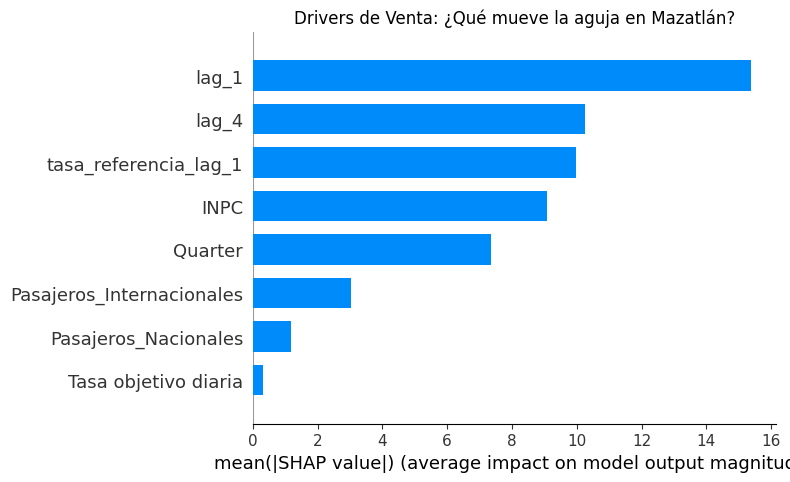

In [18]:


# --- 1. Limpieza de Datos Post-Merge ---
# Es común que al hacer merges queden NaNs si las fechas no calzan exacto.
# Usamos interpolación lineal para rellenar huecos pequeños y 'bfill'/'ffill' para extremos.
df_model = df_ventas.copy()
df_model = df_model.sort_values('Fecha').reset_index(drop=True)

# Seleccionamos las columnas numéricas para interpolar
cols_numeric = [
    'Absorción', 'Tasa objetivo diaria', 'tasa_referencia_lag_1', 
    'PEA', 'tasa_desempleo', 
    'INPC', 
    'Pasajeros_Nacionales', 'Pasajeros_Internacionales'
]

# Imputación inteligente: Interpolación lineal para suavizar la serie
df_model[cols_numeric] = df_model[cols_numeric].interpolate(method='linear', limit_direction='both')

# Rellenar cualquier restante (por ejemplo, al inicio de la serie)
df_model = df_model.fillna(method='bfill').fillna(method='ffill')

#print(f"Datos listos para modelar: {df_model.shape[0]} observaciones, {df_model.shape[1]} variables.")


class RealEstateEliteForecaster:
    def __init__(self, df, target_col='Absorción', date_col='Fecha'):
        self.df = df.copy()
        self.target_col = target_col
        self.date_col = date_col
        self.model = None
        self.feature_names = []
        
    def prepare_features(self):
        """
        Ingeniería de características para capturar estacionalidad y tendencias.
        """
        df = self.df.copy()
        
        # --- A. Fechas ---
        df['Quarter'] = df[self.date_col].dt.quarter
        df['Month'] = df[self.date_col].dt.month
        
        # --- B. Lags del Target (Autoregresión) ---
        # La venta de hace 1 trimestre influye en hoy
        df['lag_1'] = df[self.target_col].shift(1)
        # La venta de hace 1 año (estacionalidad fuerte)
        df['lag_4'] = df[self.target_col].shift(4)
        
        # --- C. Variables Exógenas (Tus datos ricos) ---
        # Nota: Usamos las columnas que ya traes del ETL
        self.exog_cols = [
            'Tasa objetivo diaria', 'tasa_referencia_lag_1', 
            #'tasa_desempleo', 
            'INPC', 
            'Pasajeros_Nacionales', 'Pasajeros_Internacionales'
        ]
        
        # Limpieza final de NaNs generados por los lags internos
        df = df.dropna().reset_index(drop=True)
        
        self.feature_names = ['Quarter', 'lag_1', 'lag_4'] + self.exog_cols
        self.data_processed = df
        return df

    def train(self):
        """
        Entrenamiento con Restricciones Monótonas (Monotone Constraints).
        Forzamos al modelo a respetar leyes económicas básicas.
        """
        X = self.data_processed[self.feature_names]
        y = self.data_processed[self.target_col]
        
        # DEFINIR RESTRICCIONES (1: Relación Positiva, -1: Relación Negativa, 0: Sin restricción)
        # Queremos:
        # - Tasa de referencia sube -> Ventas bajan (-1)
        # - INPC sube -> Ventas bajan (-1)
        # - Desempleo sube -> Ventas bajan (-1)
        # - Pasajeros suben -> Ventas suben (1)
        
        interaction_constraints = {}
        
        # Mapeamos cada columna a su restricción lógica
        constraints_tuple = []
        for col in self.feature_names:
            if 'Tasa objetivo diaria' in col:
                constraints_tuple.append(-1) # Mayor tasa, menos venta
            elif 'INPC' in col:
                constraints_tuple.append(-1) # Mayor inflación, menos venta
            # elif 'tasa_desempleo' in col:
            #     constraints_tuple.append(-1) # Mayor desempleo, menos venta
            elif 'Pasajeros' in col:
                constraints_tuple.append(1)  # Más turismo, más venta
            elif 'PEA' in col:
                constraints_tuple.append(1)  # Más gente trabajando, más venta
            else:
                constraints_tuple.append(0)  # Lags y tiempo sin restricción forzada
        
        self.model = xgb.XGBRegressor(
            n_estimators=1000,           # Subimos estimadores para que aprenda el detalle
            learning_rate=0.01,          # Aprendizaje más fino
            max_depth=4,
            subsample=0.7,
            colsample_bytree=0.8,
            objective='reg:squarederror',
            monotone_constraints=str(tuple(constraints_tuple)), # <--- AQUÍ ESTÁ LA MAGIA
            n_jobs=-1,
            random_state=42
        )
        
        self.model.fit(X, y)
        
        preds = self.model.predict(X)
        rmse = np.sqrt(mean_squared_error(y, preds))
        print(f"Modelo Re-Entrenado con Lógica Económica. RMSE: {rmse:.2f}")

    def predict_future(self, periods=4, scenarios=None):
        """
        Proyección recursiva considerando escenarios macroeconómicos.
        scenarios: Dict con tasas de crecimiento o valores fijos para variables exógenas.
        """
        last_date = self.data_processed[self.date_col].max()
        future_dates = pd.date_range(start=last_date, periods=periods+1, freq='3ME')[1:] # Trimestral
        
        future_rows = []
        last_row = self.data_processed.iloc[-1]
        
        # Valores actuales para iterar
        current_vals = last_row.copy()
        
        for date in future_dates:
            new_row = {}
            new_row[self.date_col] = date
            new_row['Quarter'] = date.quarter
            new_row['Month'] = date.month
            
            # 1. Autoregresión (Lags)
            new_row['lag_1'] = current_vals[self.target_col] # La predicción anterior es el lag de hoy
            # Simplificación para lag_4 en futuro lejano (usamos promedio reciente si no existe historia real)
            new_row['lag_4'] = current_vals['lag_4'] # Idealmente buscarías t-4 en un buffer histórico
            
            # 2. Aplicar Escenarios a Variables Exógenas
            # Si no hay escenario, asumimos "Flat" (se mantiene igual al último dato)
            for col in self.exog_cols:
                if scenarios and col in scenarios:
                    pct_change = scenarios[col]
                    new_row[col] = current_vals[col] * (1 + pct_change)
                else:
                    new_row[col] = current_vals[col]
            
            # Preparar vector para predecir
            X_future = pd.DataFrame([new_row])[self.feature_names]
            
            # Predicción
            pred_absorcion = self.model.predict(X_future)[0]
            pred_absorcion = max(0, pred_absorcion) # No ventas negativas
            
            new_row[self.target_col] = pred_absorcion
            
            # Guardar y actualizar para siguiente ciclo
            future_rows.append(new_row)
            current_vals = pd.Series(new_row)
            
        return pd.DataFrame(future_rows)

    def explain_model(self):
        """Genera valores SHAP para entender los drivers."""
        explainer = shap.TreeExplainer(self.model)
        X = self.data_processed[self.feature_names]
        shap_values = explainer.shap_values(X)
        return X, shap_values

# --- 3. EJECUCIÓN DEL ANÁLISIS ---

forecaster = RealEstateEliteForecaster(df_model)
forecaster.prepare_features()
forecaster.train()

# --- 4. EXPLICABILIDAD (SHAP) ---
# ¿Qué importa más: la tasa o los aviones?
print("\nCalculando importancia de variables (SHAP)...")
X_shap, shap_values = forecaster.explain_model()

# Resumen de impacto
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
import matplotlib.pyplot as plt
plt.title("Drivers de Venta: ¿Qué mueve la aguja en Mazatlán?")
plt.show()

In [19]:
import pandas as pd
import plotly.express as px
import numpy as np

# 1. Definición de los Drivers para cada Escenario
# Los valores representan el cambio porcentual trimestral (ej: -0.05 es bajar 5%)
escenarios_config = {
    # ------------------------------------------------------------------
    # ESCENARIO OPTIMISTA: "Dinero Barato + Poder Adquisitivo"
    # ------------------------------------------------------------------
    # Hipótesis: La FED y Banxico inician ciclo de bajas agresivas.
    # El modelo reaccionará fuertemente a la baja de tasas e inflación.
    "Optimista": {
        'tasa_referencia': -0.08,          # Bajan 8% relativo por trimestre (Agresivo, ej: 10.0% -> 9.2%)
        'tasa_referencia_lag_1': -0.08,    # Mantenemos coherencia en el lag
        'INPC': 0.005,                     # Inflación casi plana (+0.5% trimestral, target ideal)
        'tasa_desempleo': -0.05,           # El empleo crece fuerte (baja el desempleo 5% relativo)
        'Pasajeros_Nacionales': 0.05,      # Turismo crece moderadamente (Factor secundario)
        'Pasajeros_Internacionales': 0.08, 
        'PEA': 0.02                        # Más gente trabajando
    },

    # ------------------------------------------------------------------
    # ESCENARIO BASE: "Aterrizaje Suave" (Soft Landing)
    # ------------------------------------------------------------------
    # Hipótesis: Continuidad. Bajas de tasas pausadas y economía estable.
    "Base": {
        'tasa_referencia': -0.02,          # Bajan muy poco (-2% relativo, ej: 10.0% -> 9.8%)
        'tasa_referencia_lag_1': -0.02,
        'INPC': 0.012,                     # Inflación normal/controlada (+1.2% trimestral)
        'tasa_desempleo': 0.0,             # Empleo estable
        'Pasajeros_Nacionales': 0.02,      # Crecimiento inercial
        'Pasajeros_Internacionales': 0.03, 
        'PEA': 0.01
    },

    # ------------------------------------------------------------------
    # ESCENARIO PESIMISTA: "Estanflación" (Inflación Alta + Tasas Altas)
    # ------------------------------------------------------------------
    # Hipótesis: La inflación repunta y Banxico debe subir tasas de nuevo.
    # Este es el "Stress Test" real. Si el modelo soporta esto, tu proyecto es sólido.
    "Pesimista": {
        'tasa_referencia': 0.15,           # Subida BRUTAL (+15% relativo, ej: 11% -> 12.65% -> 14.5%)
        'tasa_referencia_lag_1': 0.15,
        'Pasajeros_Nacionales': -0.10,     # Caída fuerte de turismo (-10%)
        'Pasajeros_Internacionales': -0.15,
        'INPC': 0.03,                      # Inflación descontrolada
        'PEA': -0.02,                      # Destrucción de empleo
        'tasa_desempleo': 0.20             # Desempleo se dispara (+20% relativo)
    }
}
# 2. Ejecución del Bucle de Predicción
resultados_lista = []

# Primero, recuperamos la historia para graficar
df_historia = forecaster.data_processed[[forecaster.date_col, forecaster.target_col]].copy()
df_historia['Escenario'] = 'Histórico Real'
resultados_lista.append(df_historia)

print("Ejecutando simulaciones...")
resumen_ventas = {}

for nombre_escenario, params in escenarios_config.items():
    # Ejecutar predicción con los parámetros específicos
    df_proyeccion = forecaster.predict_future(periods=4, scenarios=params)
    
    # Etiquetar
    df_proyeccion['Escenario'] = nombre_escenario
    
    # Guardar en la lista global
    resultados_lista.append(df_proyeccion[[forecaster.date_col, forecaster.target_col, 'Escenario']])
    
    # Calcular KPI total para el resumen
    total_ventas = df_proyeccion[forecaster.target_col].sum()
    resumen_ventas[nombre_escenario] = int(total_ventas)
    print(f" -> {nombre_escenario}: {int(total_ventas)} unidades proyectadas.")

# 3. Consolidación
df_comparativo = pd.concat(resultados_lista, ignore_index=True)

# 4. Visualización Profesional
colores = {
    'Histórico Real': 'black',
    'Optimista': '#2ca02c',  # Verde
    'Base': '#1f77b4',       # Azul
    'Pesimista': '#d62728'   # Rojo
}

fig = px.line(
    df_comparativo, 
    x='Fecha', 
    y='Absorción', 
    color='Escenario', 
    markers=True,
    color_discrete_map=colores,
    title='Análisis de Sensibilidad: Absorción bajo 3 Escenarios Macroeconómicos',
    template='plotly_white'
)

# Línea divisoria Hoy (Fix compatible pandas 2.0)
last_hist_ts = df_historia['Fecha'].max().timestamp() * 1000
fig.add_vline(x=last_hist_ts, line_dash="dash", line_color="gray", annotation_text="Inicio Proyección")

fig.update_layout(hovermode="x unified")
fig.show()

# 5. Tabla Resumen Ejecutiva
print("\n=== RESUMEN DE ABSORCIÓN ACUMULADA (Próximos 4 Trimestres) ===")
df_resumen = pd.DataFrame(list(resumen_ventas.items()), columns=['Escenario', 'Ventas Totales'])
df_resumen['Diferencia vs Base'] = df_resumen['Ventas Totales'] - resumen_ventas['Base']
print(df_resumen.to_string(index=False))

Ejecutando simulaciones...
 -> Optimista: 472 unidades proyectadas.
 -> Base: 469 unidades proyectadas.
 -> Pesimista: 523 unidades proyectadas.



=== RESUMEN DE ABSORCIÓN ACUMULADA (Próximos 4 Trimestres) ===
Escenario  Ventas Totales  Diferencia vs Base
Optimista             472                   3
     Base             469                   0
Pesimista             523                  54


Horizontal

Modelo Re-Entrenado con Lógica Económica. RMSE: 0.73

Calculando importancia de variables (SHAP)...


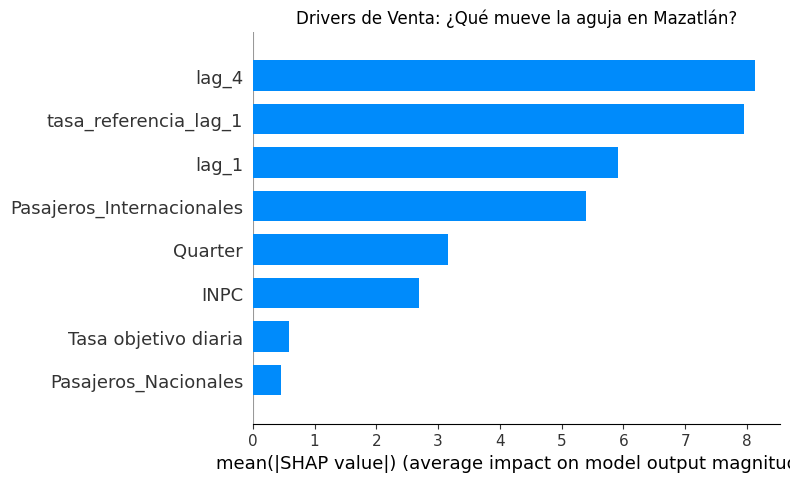

In [24]:
# 1. Preparación de tus datos
ventas_vertical_df =pd.DataFrame({
    "Fecha": [
        "2021-12","2022-03","2022-08","2022-11",
        "2023-02","2023-05","2023-08","2023-11",
        "2024-02","2024-05","2024-08","2024-11",
        "2025-02","2025-05","2025-08","2025-11"
    ],
    "Absorción": [
        36.1, 21.3, 84,64.8, 70.8, 97.5,
        42.5, 47.3, 43.3,19, 28.9, 79.3,
        40.3, 36.7, 12.63, 25
    ]
})

ventas_vertical_df["Fecha"] = pd.to_datetime(ventas_vertical_df["Fecha"])
# ============================================================
# Hacer el merge por Fecha con creditos_hipo_mazatlan_individual
# ============================================================
ventas_vertical_df = ventas_vertical_df.merge(
    creditos_hipo_mazatlan_individual,
    on="Fecha",
    how="left"
)


# ============================================================
# Hacer el merge por Fecha con df_tasa_trimestral
# ============================================================
ventas_vertical_df = ventas_vertical_df.merge(
    df_tasa_trimestral,
    on="Fecha",
    how="left"
)

# ============================================================
# Hacer el merge por Fecha con df_tasa_trimestral
# ============================================================
# Solo columnas macro que quieres traer
cols_macro = ["Fecha", "PEA", "desempleo", "tasa_desempleo"]

ventas_vertical_df = pd.merge_asof(
    ventas_vertical_df,
    df_empleo[cols_macro],
    on="Fecha",          # columna común
    direction="backward" # usa el último dato <= Fecha de ventas
)


# ============================================================
# Hacer el merge por Fecha con df_tasa_trimestral
# ============================================================
ventas_vertical_df = ventas_vertical_df.merge(
    df_inpc,
    on="Fecha",
    how="left"
)



# ============================================================
# Hacer el merge por Fecha con pasajeros de OMA
# ============================================================
ventas_vertical_df = ventas_vertical_df.merge(
    oma,
    on="Fecha",
    how="left"
)

import pandas as pd
import numpy as np

# Asegurarnos de que Fecha sea datetime y esté ordenada
ventas_vertical_df = ventas_vertical_df.sort_values('Fecha').reset_index(drop=True)

# ============================================================
# 1. Variables que se mantienen constantes hasta nuevo dato (forward fill)
#    → Ideal para tasas de interés, tasas de referencia, INPC mensual, etc.
# ============================================================
cols_ffill = [
    'Tasa objetivo diaria', 'tasa_referencia_lag_1', 'tasa_referencia_lag_2', 'tasa_referencia_lag_3',
    'INPC'
]

ventas_vertical_df[cols_ffill] = ventas_vertical_df[cols_ffill].ffill()

# ============================================================
# 2. Variables trimestrales o de baja frecuencia (PEA, desempleo, tasa_desempleo)
#    → Forward fill es lo más usado en análisis inmobiliario
# ============================================================
cols_trimestrales = ['PEA', 'desempleo', 'tasa_desempleo']
ventas_vertical_df[cols_trimestrales] = ventas_vertical_df[cols_trimestrales].ffill()

# ============================================================
# 3. Pasajeros OMA (mensuales, pero pueden tener rezago)
#    → Forward fill hasta que llegue el nuevo dato oficial
# ============================================================
cols_pasajeros = ['Pasajeros_Nacionales', 'Pasajeros_Internacionales']
ventas_vertical_df[cols_pasajeros] = ventas_vertical_df[cols_pasajeros].ffill()

# ============================================================
# 4. Créditos hipotecarios (Viviendas nuevas, existentes, Total)
#    → Si son mensuales pero faltan últimos meses → ffill razonable
#    → Si son trimestrales → también ffill
# ============================================================
# cols_creditos = ['Viviendas nuevas', 'Viviendas existentes', 'Total']
# ventas_vertical_df[cols_creditos] = ventas_vertical_df[cols_creditos].ffill()

# ============================================================
# 5. (Opcional) Si quieres ser más conservador en los últimos meses:
#     Poner NaN o 0 solo en el mes más reciente si no hay dato oficial aún
# ============================================================
# Ejemplo: dejar NaN solo en noviembre 2025 para créditos (porque aún no se publica)
# ventas_vertical_df.loc[ventas_vertical_df['Fecha'] >= '2025-11-01', cols_creditos] = np.nan

# ============================================================
# Revisar resultado final
# ============================================================
#print(ventas_vertical_df.isna().sum())  # Debe salir todo en 0 (o solo últimos si aplicaste opcional)

# Revisar resultado
#ventas_vertical_df
 

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error

# --- 1. Limpieza de Datos Post-Merge ---
# Es común que al hacer merges queden NaNs si las fechas no calzan exacto.
# Usamos interpolación lineal para rellenar huecos pequeños y 'bfill'/'ffill' para extremos.
df_model = ventas_vertical_df.copy()
df_model = df_model.sort_values('Fecha').reset_index(drop=True)

# Seleccionamos las columnas numéricas para interpolar
cols_numeric = [
    'Absorción', 'Tasa objetivo diaria', 'tasa_referencia_lag_1', 
    'PEA', 'tasa_desempleo', 'INPC', 
    'Pasajeros_Nacionales', 'Pasajeros_Internacionales'
]

# Imputación inteligente: Interpolación lineal para suavizar la serie
df_model[cols_numeric] = df_model[cols_numeric].interpolate(method='linear', limit_direction='both')

# Rellenar cualquier restante (por ejemplo, al inicio de la serie)
df_model = df_model.fillna(method='bfill').fillna(method='ffill')

#print(f"Datos listos para modelar: {df_model.shape[0]} observaciones, {df_model.shape[1]} variables.")


# --- 3. EJECUCIÓN DEL ANÁLISIS ---

forecaster = RealEstateEliteForecaster(df_model)
forecaster.prepare_features()
forecaster.train()

# DEFINICIÓN DE ESCENARIOS (Aquí tú controlas la visión de negocio)
# Ejemplo: "La tasa bajará levemente (-1% trimestral) y el turismo subirá (+2%)"
mis_escenarios = {
    'Tasa objetivo diaria': -0.01,          # Tasa baja 1% cada trimestre
    'tasa_referencia_lag_1': -0.01,
    'Pasajeros_Nacionales': 0.02,      # Turismo nacional crece 2%
    'Pasajeros_Internacionales': 0.05, # Turismo inter. crece 5% (Temporada alta)
    'INPC': 0.01                       # Inflación controlada 1%
}

df_future = forecaster.predict_future(periods=4, scenarios=mis_escenarios)

# --- 4. VISUALIZACIÓN DE RESULTADOS ---

# Unir histórico y futuro
historia = forecaster.data_processed[[forecaster.date_col, forecaster.target_col]].copy()
historia['Tipo'] = 'Histórico Real'
df_future_viz = df_future[[forecaster.date_col, forecaster.target_col]].copy()
df_future_viz['Tipo'] = 'Proyección (Escenario Base)'

df_total = pd.concat([historia, df_future_viz], ignore_index=True)

# Gráfica Interactiva
# fig = px.line(df_total, x='Fecha', y='Absorción', color='Tipo', markers=True,
#               title='Proyección de Absorción Mazatlán: Impacto de Tasas y Turismo',
#               color_discrete_map={'Histórico Real': '#1f77b4', 'Proyección (Escenario Base)': '#2ca02c'})

# # Línea vertical divisoria (Fix Pandas 2.0 compatible)
# last_hist_ts = historia['Fecha'].max().timestamp() * 1000
# fig.add_vline(x=last_hist_ts, line_dash="dash", line_color="gray", annotation_text="Hoy")

# fig.show()

# --- 5. EXPLICABILIDAD (SHAP) ---
# ¿Qué importa más: la tasa o los aviones?
print("\nCalculando importancia de variables (SHAP)...")
X_shap, shap_values = forecaster.explain_model()

# Resumen de impacto
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
import matplotlib.pyplot as plt
plt.title("Drivers de Venta: ¿Qué mueve la aguja en Mazatlán?")
plt.show()

In [25]:
import pandas as pd
import plotly.express as px
import numpy as np

# 1. Definición de los Drivers para cada Escenario
# Los valores representan el cambio porcentual trimestral (ej: -0.05 es bajar 5%)
escenarios_config = {
    # ------------------------------------------------------------------
    # ESCENARIO OPTIMISTA: "Mazatlán de Moda + Pleno Empleo"
    # ------------------------------------------------------------------
    # Hipótesis: Temporada récord de turismo internacional y economía local vibrante.
    "Optimista": {
        # Driver Principal 1: Turismo Internacional explota (+12% trimestral)
        'Pasajeros_Internacionales': 0.12, 
        
        # Driver Principal 2: Desempleo baja fuerte (-10% relativo) -> Gente con dinero
        'tasa_desempleo': -0.10,           
        
        # Drivers Secundarios (Ayudan, pero menos)
        'Pasajeros_Nacionales': 0.05,      # Turismo nacional acompaña
        'INPC': 0.005,                     # Inflación baja
        'PEA': 0.02,                       # Más fuerza laboral
        
        # La tasa ya no importa tanto, la dejamos estable o bajando leve
        'tasa_referencia': -0.02,          
        'tasa_referencia_lag_1': -0.02
    },

    # ------------------------------------------------------------------
    # ESCENARIO BASE: "Inercia Actual"
    # ------------------------------------------------------------------
    # Hipótesis: El mercado sigue su curso natural con crecimiento moderado.
    "Base": {
        'Pasajeros_Internacionales': 0.03, # Crecimiento normal (+3%)
        'tasa_desempleo': 0.0,             # Empleo estable
        'Pasajeros_Nacionales': 0.02,
        'INPC': 0.01,
        'PEA': 0.01,
        'tasa_referencia': 0.0,
        'tasa_referencia_lag_1': 0.0
    },

    # ------------------------------------------------------------------
    # ESCENARIO PESIMISTA: "Crisis Turística o Warning de Viaje"
    # ------------------------------------------------------------------
    # Hipótesis: Algo asusta al turismo internacional (Warning de seguridad)
    # y golpea el empleo local.
    "Pesimista": {
        # El golpe fuerte: Se van los extranjeros (-20%)
        'Pasajeros_Internacionales': -0.20, 
        
        # Crisis económica local: Sube el desempleo (+15%)
        'tasa_desempleo': 0.15,            
        
        # Contracción general
        'Pasajeros_Nacionales': -0.05,
        'INPC': 0.03,                      # Costo de vida sube
        'PEA': -0.01,                      # Gente deja de buscar trabajo
        
        # Aunque la tasa no pinte tanto, en crisis suele subir
        'tasa_referencia': 0.05,
        'tasa_referencia_lag_1': 0.05
    }
}
# 2. Ejecución del Bucle de Predicción
resultados_lista = []

# Primero, recuperamos la historia para graficar
df_historia = forecaster.data_processed[[forecaster.date_col, forecaster.target_col]].copy()
df_historia['Escenario'] = 'Histórico Real'
resultados_lista.append(df_historia)

print("Ejecutando simulaciones...")
resumen_ventas = {}

for nombre_escenario, params in escenarios_config.items():
    # Ejecutar predicción con los parámetros específicos
    df_proyeccion = forecaster.predict_future(periods=4, scenarios=params)
    
    # Etiquetar
    df_proyeccion['Escenario'] = nombre_escenario
    
    # Guardar en la lista global
    resultados_lista.append(df_proyeccion[[forecaster.date_col, forecaster.target_col, 'Escenario']])
    
    # Calcular KPI total para el resumen
    total_ventas = df_proyeccion[forecaster.target_col].sum()
    resumen_ventas[nombre_escenario] = int(total_ventas)
    print(f" -> {nombre_escenario}: {int(total_ventas)} unidades proyectadas.")

# 3. Consolidación
df_comparativo = pd.concat(resultados_lista, ignore_index=True)

# 4. Visualización Profesional
colores = {
    'Histórico Real': 'black',
    'Optimista': '#2ca02c',  # Verde
    'Base': '#1f77b4',       # Azul
    'Pesimista': '#d62728'   # Rojo
}

fig = px.line(
    df_comparativo, 
    x='Fecha', 
    y='Absorción', 
    color='Escenario', 
    markers=True,
    color_discrete_map=colores,
    title='Análisis de Sensibilidad: Absorción bajo 3 Escenarios Macroeconómicos',
    template='plotly_white'
)

# Línea divisoria Hoy (Fix compatible pandas 2.0)
last_hist_ts = df_historia['Fecha'].max().timestamp() * 1000
fig.add_vline(x=last_hist_ts, line_dash="dash", line_color="gray", annotation_text="Inicio Proyección")

fig.update_layout(hovermode="x unified")
fig.show()

# 5. Tabla Resumen Ejecutiva
print("\n=== RESUMEN DE ABSORCIÓN ACUMULADA (Próximos 4 Trimestres) ===")
df_resumen = pd.DataFrame(list(resumen_ventas.items()), columns=['Escenario', 'Ventas Totales'])
df_resumen['Diferencia vs Base'] = df_resumen['Ventas Totales'] - resumen_ventas['Base']
print(df_resumen.to_string(index=False))

Ejecutando simulaciones...
 -> Optimista: 115 unidades proyectadas.
 -> Base: 112 unidades proyectadas.
 -> Pesimista: 64 unidades proyectadas.



=== RESUMEN DE ABSORCIÓN ACUMULADA (Próximos 4 Trimestres) ===
Escenario  Ventas Totales  Diferencia vs Base
Optimista             115                   3
     Base             112                   0
Pesimista              64                 -48


Lote

Modelo Re-Entrenado con Lógica Económica. RMSE: 1.44

Calculando importancia de variables (SHAP)...


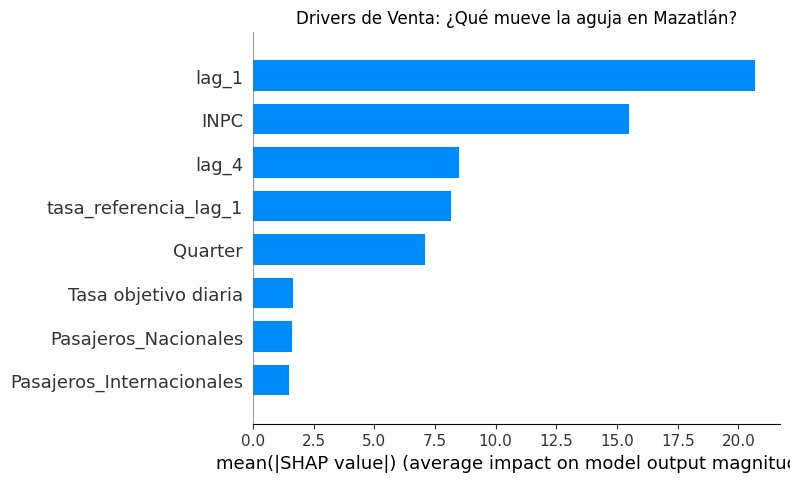

In [28]:
# 1. Preparación de tus datos
ventas_vertical_df = pd.DataFrame({
    "Fecha": [
        "2021-12","2022-03","2022-08","2022-11",
        "2023-02","2023-05","2023-08","2023-11",
        "2024-02","2024-05","2024-08","2024-11",
        "2025-02","2025-05","2025-08","2025-11"
    ],
    "Absorción": [
        264.4, 130.1, 186.7, 263.9, 214.9, 241.5,
       152.7, 152.8, 83.5, 206.5, 158.6, 132.6,
        80.2, 47.6, 137.9, 134
    ]
})

ventas_vertical_df["Fecha"] = pd.to_datetime(ventas_vertical_df["Fecha"])
# ============================================================
# Hacer el merge por Fecha con creditos_hipo_mazatlan_individual
# ============================================================
ventas_vertical_df = ventas_vertical_df.merge(
    creditos_hipo_mazatlan_individual,
    on="Fecha",
    how="left"
)


# ============================================================
# Hacer el merge por Fecha con df_tasa_trimestral
# ============================================================
ventas_vertical_df = ventas_vertical_df.merge(
    df_tasa_trimestral,
    on="Fecha",
    how="left"
)

# ============================================================
# Hacer el merge por Fecha con df_tasa_trimestral
# ============================================================
# Solo columnas macro que quieres traer
cols_macro = ["Fecha", "PEA", "desempleo", "tasa_desempleo"]

ventas_vertical_df = pd.merge_asof(
    ventas_vertical_df,
    df_empleo[cols_macro],
    on="Fecha",          # columna común
    direction="backward" # usa el último dato <= Fecha de ventas
)


# ============================================================
# Hacer el merge por Fecha con df_tasa_trimestral
# ============================================================
ventas_vertical_df = ventas_vertical_df.merge(
    df_inpc,
    on="Fecha",
    how="left"
)



# ============================================================
# Hacer el merge por Fecha con pasajeros de OMA
# ============================================================
ventas_vertical_df = ventas_vertical_df.merge(
    oma,
    on="Fecha",
    how="left"
)

import pandas as pd
import numpy as np

# Asegurarnos de que Fecha sea datetime y esté ordenada
ventas_vertical_df = ventas_vertical_df.sort_values('Fecha').reset_index(drop=True)

# ============================================================
# 1. Variables que se mantienen constantes hasta nuevo dato (forward fill)
#    → Ideal para tasas de interés, tasas de referencia, INPC mensual, etc.
# ============================================================
cols_ffill = [
    'Tasa objetivo diaria', 'tasa_referencia_lag_1', 'tasa_referencia_lag_2', 'tasa_referencia_lag_3',
    'INPC'
]

ventas_vertical_df[cols_ffill] = ventas_vertical_df[cols_ffill].ffill()

# ============================================================
# 2. Variables trimestrales o de baja frecuencia (PEA, desempleo, tasa_desempleo)
#    → Forward fill es lo más usado en análisis inmobiliario
# ============================================================
cols_trimestrales = ['PEA', 'desempleo', 'tasa_desempleo']
ventas_vertical_df[cols_trimestrales] = ventas_vertical_df[cols_trimestrales].ffill()

# ============================================================
# 3. Pasajeros OMA (mensuales, pero pueden tener rezago)
#    → Forward fill hasta que llegue el nuevo dato oficial
# ============================================================
cols_pasajeros = ['Pasajeros_Nacionales', 'Pasajeros_Internacionales']
ventas_vertical_df[cols_pasajeros] = ventas_vertical_df[cols_pasajeros].ffill()

# ============================================================
# 4. Créditos hipotecarios (Viviendas nuevas, existentes, Total)
#    → Si son mensuales pero faltan últimos meses → ffill razonable
#    → Si son trimestrales → también ffill
# ============================================================
# cols_creditos = ['Viviendas nuevas', 'Viviendas existentes', 'Total']
# ventas_vertical_df[cols_creditos] = ventas_vertical_df[cols_creditos].ffill()

# ============================================================
# 5. (Opcional) Si quieres ser más conservador en los últimos meses:
#     Poner NaN o 0 solo en el mes más reciente si no hay dato oficial aún
# ============================================================
# Ejemplo: dejar NaN solo en noviembre 2025 para créditos (porque aún no se publica)
# ventas_vertical_df.loc[ventas_vertical_df['Fecha'] >= '2025-11-01', cols_creditos] = np.nan

# ============================================================
# Revisar resultado final
# ============================================================
#print(ventas_vertical_df.isna().sum())  # Debe salir todo en 0 (o solo últimos si aplicaste opcional)

# Revisar resultado
#ventas_vertical_df
 

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error

# --- 1. Limpieza de Datos Post-Merge ---
# Es común que al hacer merges queden NaNs si las fechas no calzan exacto.
# Usamos interpolación lineal para rellenar huecos pequeños y 'bfill'/'ffill' para extremos.
df_model = ventas_vertical_df.copy()
df_model = df_model.sort_values('Fecha').reset_index(drop=True)

# Seleccionamos las columnas numéricas para interpolar
cols_numeric = [
    'Absorción', 'Tasa objetivo diaria', 'tasa_referencia_lag_1', 
    'PEA', 'tasa_desempleo', 'INPC', 
    'Pasajeros_Nacionales', 'Pasajeros_Internacionales'
]

# Imputación inteligente: Interpolación lineal para suavizar la serie
df_model[cols_numeric] = df_model[cols_numeric].interpolate(method='linear', limit_direction='both')

# Rellenar cualquier restante (por ejemplo, al inicio de la serie)
df_model = df_model.fillna(method='bfill').fillna(method='ffill')

#print(f"Datos listos para modelar: {df_model.shape[0]} observaciones, {df_model.shape[1]} variables.")

# --- 3. EJECUCIÓN DEL ANÁLISIS ---

forecaster = RealEstateEliteForecaster(df_model)
forecaster.prepare_features()
forecaster.train()

# # DEFINICIÓN DE ESCENARIOS (Aquí tú controlas la visión de negocio)
# # Ejemplo: "La tasa bajará levemente (-1% trimestral) y el turismo subirá (+2%)"
# mis_escenarios = {
#     'tasa_referencia': -0.01,          # Tasa baja 1% cada trimestre
#     'tasa_referencia_lag_1': -0.01,
#     'Pasajeros_Nacionales': 0.02,      # Turismo nacional crece 2%
#     'Pasajeros_Internacionales': 0.05, # Turismo inter. crece 5% (Temporada alta)
#     'INPC': 0.01                       # Inflación controlada 1%
# }

# df_future = forecaster.predict_future(periods=4, scenarios=mis_escenarios)

# # --- 4. VISUALIZACIÓN DE RESULTADOS ---

# # Unir histórico y futuro
# historia = forecaster.data_processed[[forecaster.date_col, forecaster.target_col]].copy()
# historia['Tipo'] = 'Histórico Real'
# df_future_viz = df_future[[forecaster.date_col, forecaster.target_col]].copy()
# df_future_viz['Tipo'] = 'Proyección (Escenario Base)'

# df_total = pd.concat([historia, df_future_viz], ignore_index=True)

# # Gráfica Interactiva
# fig = px.line(df_total, x='Fecha', y='Absorción', color='Tipo', markers=True,
#               title='Proyección de Absorción Mazatlán: Impacto de Tasas y Turismo',
#               color_discrete_map={'Histórico Real': '#1f77b4', 'Proyección (Escenario Base)': '#2ca02c'})

# # Línea vertical divisoria (Fix Pandas 2.0 compatible)
# last_hist_ts = historia['Fecha'].max().timestamp() * 1000
# fig.add_vline(x=last_hist_ts, line_dash="dash", line_color="gray", annotation_text="Hoy")

# fig.show()

# # --- 5. EXPLICABILIDAD (SHAP) ---
# ¿Qué importa más: la tasa o los aviones?
print("\nCalculando importancia de variables (SHAP)...")
X_shap, shap_values = forecaster.explain_model()

# Resumen de impacto
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
import matplotlib.pyplot as plt
plt.title("Drivers de Venta: ¿Qué mueve la aguja en Mazatlán?")
plt.show()

In [29]:
import pandas as pd
import plotly.express as px
import numpy as np

# 1. Definición de los Drivers para cada Escenario
# Los valores representan el cambio porcentual trimestral (ej: -0.05 es bajar 5%)
escenarios_config = {
    # ----------------------------------------------------------
    # OPTIMISTA: “Desinflación + tasas a la baja + empleo fuerte”
    # ----------------------------------------------------------
    "Optimista": {
        # Drivers fuertes (según SHAP)
        "INPC": -0.02,              # inflación baja (mejora poder adquisitivo)
        "tasa_desempleo": -0.08,    # baja desempleo
        "tasa_referencia": -0.04,   # bajan tasas
        "tasa_referencia_lag_1": -0.04,

        # Drivers débiles (según SHAP): ajustes moderados
        "Pasajeros_Nacionales": 0.02,
        "Pasajeros_Internacionales": 0.03,
    },

    # ----------------------------------------------------------
    # BASE: “Inercia actual + macro estable”
    # ----------------------------------------------------------
    "Base": {
        "INPC": 0.00,
        "tasa_desempleo": 0.00,
        "tasa_referencia": 0.00,
        "tasa_referencia_lag_1": 0.00,
        "Pasajeros_Nacionales": 0.00,
        "Pasajeros_Internacionales": 0.00,
    },

    # ----------------------------------------------------------
    # PESIMISTA: “Rebrote inflacionario + tasas altas + desempleo”
    # ----------------------------------------------------------
    "Pesimista": {
        "INPC": 0.03,               # inflación sube
        "tasa_desempleo": 0.10,     # sube desempleo
        "tasa_referencia": 0.06,    # tasas suben
        "tasa_referencia_lag_1": 0.06,

        # Turismo cae, pero ya no manda: shock moderado
        "Pasajeros_Nacionales": -0.03,
        "Pasajeros_Internacionales": -0.05,
    }
}

# 2. Ejecución del Bucle de Predicción
resultados_lista = []

# Primero, recuperamos la historia para graficar
df_historia = forecaster.data_processed[[forecaster.date_col, forecaster.target_col]].copy()
df_historia['Escenario'] = 'Histórico Real'
resultados_lista.append(df_historia)

print("Ejecutando simulaciones...")
resumen_ventas = {}

for nombre_escenario, params in escenarios_config.items():
    # Ejecutar predicción con los parámetros específicos
    df_proyeccion = forecaster.predict_future(periods=4, scenarios=params)
    
    # Etiquetar
    df_proyeccion['Escenario'] = nombre_escenario
    
    # Guardar en la lista global
    resultados_lista.append(df_proyeccion[[forecaster.date_col, forecaster.target_col, 'Escenario']])
    
    # Calcular KPI total para el resumen
    total_ventas = df_proyeccion[forecaster.target_col].sum()
    resumen_ventas[nombre_escenario] = int(total_ventas)
    print(f" -> {nombre_escenario}: {int(total_ventas)} unidades proyectadas.")

# 3. Consolidación
df_comparativo = pd.concat(resultados_lista, ignore_index=True)

# 4. Visualización Profesional
colores = {
    'Histórico Real': 'black',
    'Optimista': '#2ca02c',  # Verde
    'Base': '#1f77b4',       # Azul
    'Pesimista': '#d62728'   # Rojo
}

fig = px.line(
    df_comparativo, 
    x='Fecha', 
    y='Absorción', 
    color='Escenario', 
    markers=True,
    color_discrete_map=colores,
    title='Análisis de Sensibilidad: Absorción bajo 3 Escenarios Macroeconómicos',
    template='plotly_white'
)

# Línea divisoria Hoy (Fix compatible pandas 2.0)
last_hist_ts = df_historia['Fecha'].max().timestamp() * 1000
fig.add_vline(x=last_hist_ts, line_dash="dash", line_color="gray", annotation_text="Inicio Proyección")

fig.update_layout(hovermode="x unified")
fig.show()

# 5. Tabla Resumen Ejecutiva
print("\n=== RESUMEN DE ABSORCIÓN ACUMULADA (Próximos 4 Trimestres) ===")
df_resumen = pd.DataFrame(list(resumen_ventas.items()), columns=['Escenario', 'Ventas Totales'])
df_resumen['Diferencia vs Base'] = df_resumen['Ventas Totales'] - resumen_ventas['Base']
print(df_resumen.to_string(index=False))

Ejecutando simulaciones...
 -> Optimista: 451 unidades proyectadas.
 -> Base: 450 unidades proyectadas.
 -> Pesimista: 403 unidades proyectadas.



=== RESUMEN DE ABSORCIÓN ACUMULADA (Próximos 4 Trimestres) ===
Escenario  Ventas Totales  Diferencia vs Base
Optimista             451                   1
     Base             450                   0
Pesimista             403                 -47
